# Прогнозирование акций Теслы

# Загрузка данных

+ https://www.datasource.ai/uploads/1c79c40efac8fff409e7c23fe8167d04.html

+ [finance.yahoo.com](https://finance.yahoo.com/quote/TSLA/chart?p=TSLA#eyJpbnRlcnZhbCI6ImRheSIsInBlcmlvZGljaXR5IjoxLCJ0aW1lVW5pdCI6bnVsbCwiY2FuZGxlV2lkdGgiOjEsImZsaXBwZWQiOmZhbHNlLCJ2b2x1bWVVbmRlcmxheSI6dHJ1ZSwiYWRqIjp0cnVlLCJjcm9zc2hhaXIiOnRydWUsImNoYXJ0VHlwZSI6ImxpbmUiLCJleHRlbmRlZCI6ZmFsc2UsIm1hcmtldFNlc3Npb25zIjp7fSwiYWdncmVnYXRpb25UeXBlIjoib2hsYyIsImNoYXJ0U2NhbGUiOiJsaW5lYXIiLCJwYW5lbHMiOnsiY2hhcnQiOnsicGVyY2VudCI6MSwiZGlzcGxheSI6IlRTTEEiLCJjaGFydE5hbWUiOiJjaGFydCIsImluZGV4IjowLCJ5QXhpcyI6eyJuYW1lIjoiY2hhcnQiLCJwb3NpdGlvbiI6bnVsbH0sInlheGlzTEhTIjpbXSwieWF4aXNSSFMiOlsiY2hhcnQiLCLigIx2b2wgdW5kcuKAjCJdfX0sInNldFNwYW4iOm51bGwsImxpbmVXaWR0aCI6Miwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImV2ZW50cyI6dHJ1ZSwiY29sb3IiOiIjMDA4MWYyIiwic3RyaXBlZEJhY2tncm91ZCI6dHJ1ZSwicmFuZ2UiOm51bGwsImV2ZW50TWFwIjp7ImNvcnBvcmF0ZSI6eyJkaXZzIjp0cnVlLCJzcGxpdHMiOnRydWV9LCJzaWdEZXYiOnt9fSwic3ltYm9scyI6W3sic3ltYm9sIjoiVFNMQSIsInN5bWJvbE9iamVjdCI6eyJzeW1ib2wiOiJUU0xBIiwicXVvdGVUeXBlIjoiRVFVSVRZIiwiZXhjaGFuZ2VUaW1lWm9uZSI6IkFtZXJpY2EvTmV3X1lvcmsifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoiZGF5IiwidGltZVVuaXQiOm51bGwsInNldFNwYW4iOm51bGx9XSwic3R1ZGllcyI6eyLigIx2b2wgdW5kcuKAjCI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiaWQiOiLigIx2b2wgdW5kcuKAjCIsImRpc3BsYXkiOiLigIx2b2wgdW5kcuKAjCJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwMGIwNjEiLCJEb3duIFZvbHVtZSI6IiNmZjMzM2EifSwicGFuZWwiOiJjaGFydCIsInBhcmFtZXRlcnMiOnsid2lkdGhGYWN0b3IiOjAuNDUsImNoYXJ0TmFtZSI6ImNoYXJ0IiwicGFuZWxOYW1lIjoiY2hhcnQifX19fQ--)

In [19]:
# !pip install pandas-datareader
# !pip install tensorflow

In [1]:
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Dropout, Flatten, GRU, SimpleRNN
from keras.utils import set_random_seed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

In [2]:
pd.set_option("display.max_columns", 100)

In [3]:
# end = pd.Timestamp.now() 
end = '2022-11-29'
# start = end - pd.DateOffset(years=5)
start = '2014-11-29'
# start = '2019-11-29'
print(f'{end},\n{start}')

2022-11-29,
2014-11-29


In [65]:
df = pdr.DataReader("TSLA",
                    data_source='yahoo',
                    start=start,
                    end=end,
                    )

df.drop('Close', axis=1, inplace=True)
df.rename(columns={'Adj Close': 'Close'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2014 entries, 2014-12-01 to 2022-11-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    2014 non-null   float64
 1   Low     2014 non-null   float64
 2   Open    2014 non-null   float64
 3   Volume  2014 non-null   float64
 4   Close   2014 non-null   float64
dtypes: float64(5)
memory usage: 94.4 KB


Свечной график:
+ https://medium.com/codex/creating-candlestick-charts-using-python-plotly-8081c4820351

In [66]:
# Свечной график
candlestick = go.Candlestick(x=df.index,
                             open=df['Open'],
                             high=df['High'],
                             low=df['Low'],
                             close=df['Close'],
                             showlegend=False,
                             )

# график объема
volume = go.Bar(x=df.index,
                y=df.Volume,
                showlegend=False,
                marker_color='rgb(55, 83, 109)',
                )

# создание общего графика
fig = make_subplots(rows=2,
                    cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.1,
                    subplot_titles=('OHLC', 'Volume'),
                    row_width=[0.3, 0.7]
                    )


fig.add_trace(candlestick, row=1, col=1)
fig.add_trace(volume, row=2, col=1)

fig.update_layout(title="Tesla stock dynamics", height=600)
fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_yaxes(title_text="Price (USD)", row=1, col=1)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

# Feature Engineering
+ https://towardsdatascience.com/technical-analysis-library-to-financial-datasets-with-pandas-python-4b2b390d3543

## Индекс S&P 500

+ https://ru.wikipedia.org/wiki/S%26P_500

In [67]:
# индекс S&P 500 "^GSPC"
df_sp500 = pdr.DataReader("SPY",
                          data_source='yahoo',
                          start=start,
                          end=end,
                          )

df_sp500 = df_sp500[['Adj Close']].rename({'Adj Close': 'SP500'}, axis=1)
df = df.join(df_sp500)
df.head()

,High,Low,Open,Volume,Close,SP500
Date,,,,,,
2014-12-01,16.164667,15.267333,16.077333,129291000.0,15.442667,177.584793
2014-12-02,15.658667,15.200000,15.638000,88305000.0,15.428667,178.732651
2014-12-03,15.314667,15.033333,15.083333,79615500.0,15.286667,179.423126
2014-12-04,15.393333,15.187333,15.240000,57834000.0,15.218667,179.224594
2014-12-05,15.292667,14.817333,15.244667,90954000.0,14.914000,179.518051


https://pythonguides.com/matplotlib-two-y-axes/

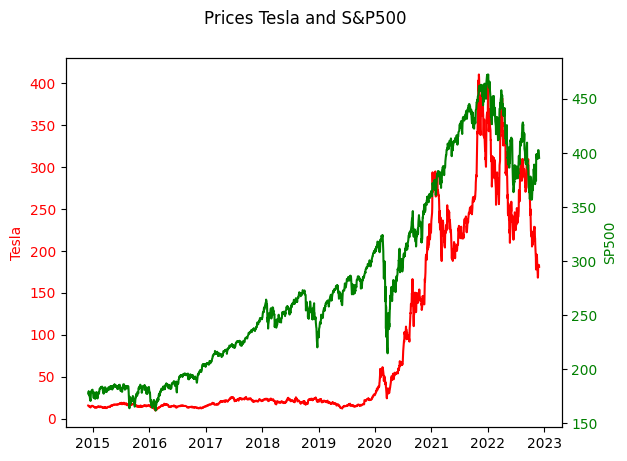

In [68]:
fig, ax1 = plt.subplots()
fig.suptitle('Prices Tesla and S&P500')

ax1.plot(df['Close'], color='red')
ax1.set_ylabel('Tesla', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(df['SP500'], color='green')
ax2.set_ylabel('SP500', color='green')
ax2.tick_params(axis='y', labelcolor='green')

## Децильность

In [69]:
# df['<100'] = (df['Close'] < 80).astype(int)

## VWAP
+ https://stackoverflow.com/questions/29298789/pandas-efficient-vwap-calculation
+ https://academy.binance.com/ru/articles/volume-weighted-average-price-vwap-explained

<AxesSubplot: >

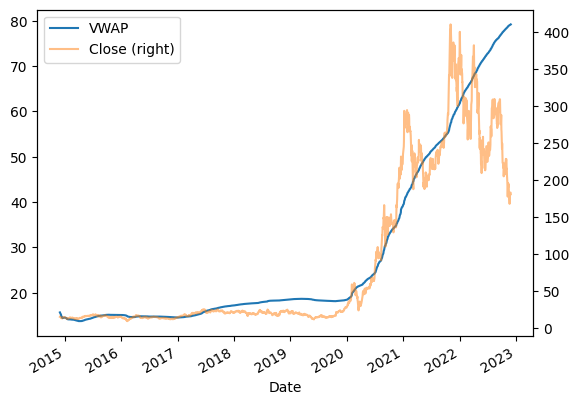

In [70]:
tp = df[['Low', 'High', 'Close']].mean(axis=1)
df['VWAP'] = (tp * df['Volume']).cumsum() / df['Volume'].cumsum()

fig, ax = plt.subplots()
df['VWAP'].plot(ax=ax, legend=True)
df['Close'].plot(ax=ax, secondary_y=True, alpha=0.5, legend=True)

## Разность, направление

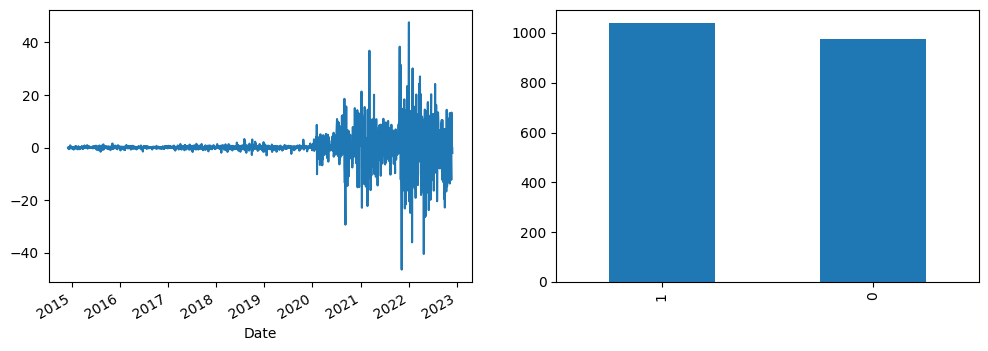

In [71]:
df['Diff_closes'] = df['Close'].diff()
df['direction'] = (df['Close'] > df['Close'].shift()).astype(int)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
df['Diff_closes'].plot(ax=ax[0])
df['direction'].value_counts().plot(kind='bar', ax=ax[1]);

In [72]:
def class_weights(y):
    return len(y) / (len(np.unique(y)) * np.bincount(y)) 

In [73]:
y = df['direction']
c = np.bincount(y) 
w = class_weights(y)
c * w, len(y)

(array([1007., 1007.]), 2014)

## ATR, ADX
+ https://medium.com/codex/algorithmic-trading-with-average-directional-index-in-python-2b5a20ecf06a
+ https://www.learnpythonwithrune.org/calculate-the-average-true-range-atr-easy-with-pandas-dataframes/

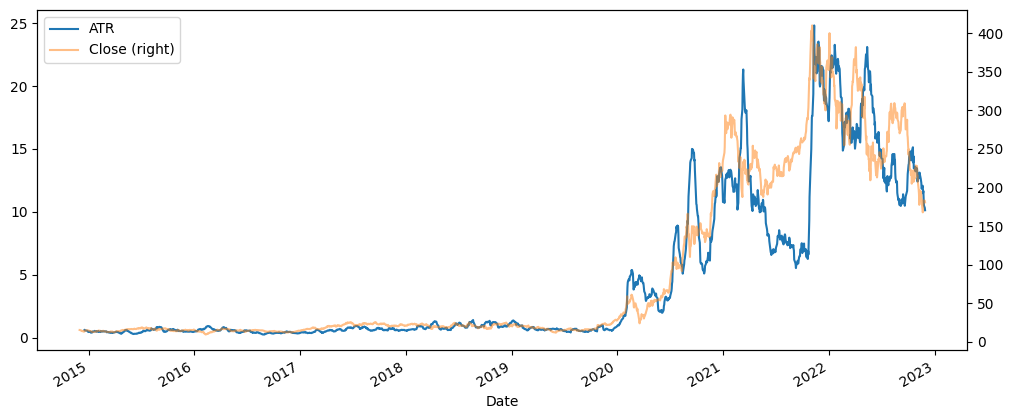

In [74]:
lookback = 14

high_low = df['High'] - df['Low']
high_close = np.abs(df['High'] - df['Close'].shift())
low_close = np.abs(df['Low'] - df['Close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
df['ATR'] = true_range.rolling(lookback).mean()

fig, ax = plt.subplots(figsize=(12, 5))
df['ATR'].plot(ax=ax, legend=True)
df['Close'].plot(ax=ax, secondary_y=True, alpha=0.5, legend=True);

<AxesSubplot: >

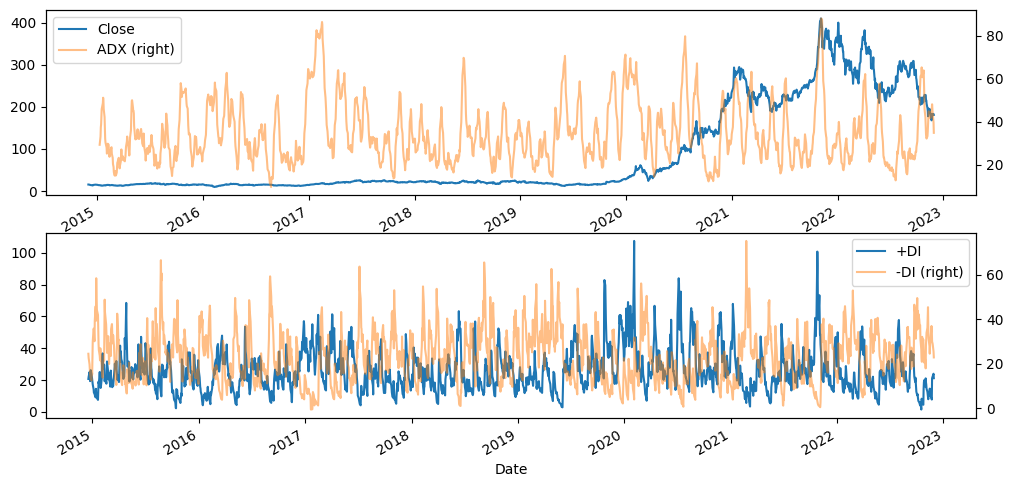

In [75]:
high_diff = df['High'].diff()
low_diff = -df['Low'].diff()

df['+DM'] = np.where(high_diff > low_diff, high_diff, 0)
df['-DM'] = np.where(low_diff > high_diff, low_diff, 0)

df['+DI'] = (df['+DM'].ewm(span=lookback, min_periods=lookback, adjust=False).mean() / df['ATR']) * 100
df['-DI'] = (df['-DM'].ewm(span=lookback, min_periods=lookback, adjust=False).mean() / df['ATR']) * 100

di = np.abs(df['+DI'] - df['-DI']) / np.abs(df['+DI'] + df['-DI']) * 100
adx = (di.shift() * (lookback-1) + di) / lookback
df['ADX'] = adx.ewm(span=lookback, min_periods=lookback, adjust=False).mean()

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
df['Close'].plot(ax=ax[0], legend=True)
df['ADX'].plot(ax=ax[0], legend=True, secondary_y=True, alpha=0.5)
df['+DI'].plot(ax=ax[1], legend=True)
df['-DI'].plot(ax=ax[1], legend=True, secondary_y=True, alpha=0.5)

## Return, Volatility

Rate of Change = Simple Rate of Return.

+ https://dspyt.com/simple-returns-log-return-and-volatility-simple-introduction
+ https://www.wallstreetmojo.com/realized-volatility/
+ https://allthesnippets.com/notes/finance/calculating_cumulative_returns_of_stocks_with_python_and_pandas.html

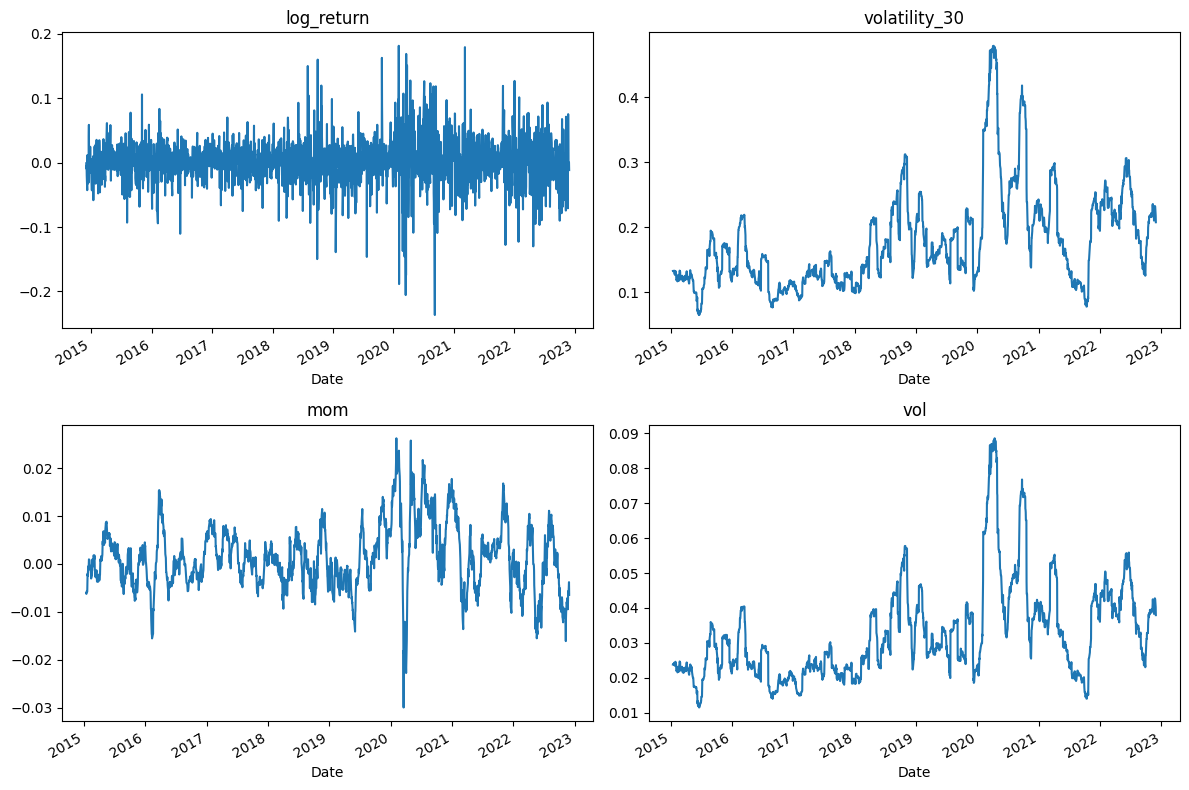

In [185]:
window = 30
df['simple_return'] = df['Close'].pct_change()
df['log_return'] = np.log(df['Close']).diff()
df['log_return_square'] = df['log_return'] ** 2

df['mom'] = df['log_return'].rolling(window).mean()
df['vol'] = df['log_return'].rolling(window).std()

df['volatility_30'] = np.sqrt(df['log_return_square'].rolling(30).sum())
df['volatility_60'] = np.sqrt(df['log_return_square'].rolling(60).sum())
df['volatility_100'] = np.sqrt(df['log_return_square'].rolling(100).sum())

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
df['log_return'].plot(ax=axes[0, 0], title='log_return')
df['volatility_30'].plot(ax=axes[0, 1], title='volatility_30')
df['mom'].plot(ax=axes[1, 0], title='mom')
df['vol'].plot(ax=axes[1, 1], title='vol');
plt.tight_layout()

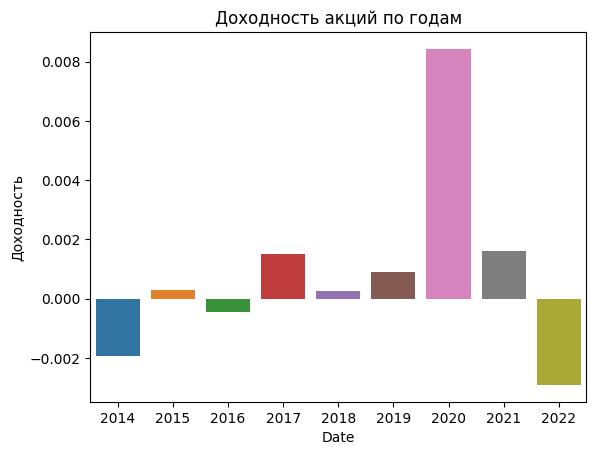

In [186]:
year_returns = df.resample('1Y')['log_return'].mean()

sns.barplot(y=year_returns.values, x=year_returns.index.year)
plt.ylabel('Доходность')
plt.title('Доходность акций по годам');

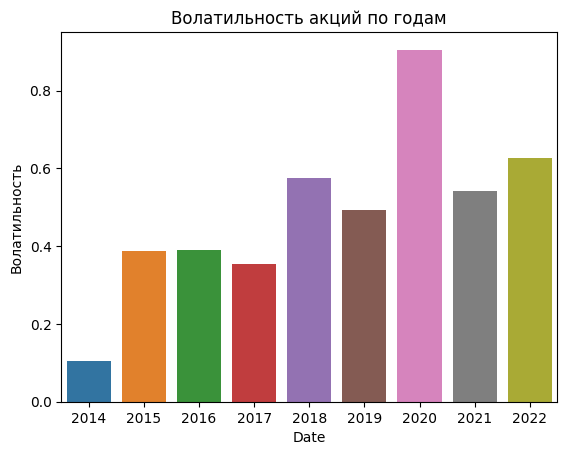

In [78]:
year_returns = np.sqrt(df.resample('1Y')['log_return_square'].sum())

sns.barplot(y=year_returns.values, x=year_returns.index.year)
plt.ylabel('Волатильность')
plt.title('Волатильность акций по годам');

## Sharpe ratio
+ https://www.codearmo.com/blog/sharpe-sortino-and-calmar-ratios-python
+ https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%A8%D0%B0%D1%80%D0%BF%D0%B0

In [79]:
def sharpe_ratio(series, n, rf):
    numerator = (series - rf).mean() * n
    denominator = series.std() * np.sqrt(n)
    return numerator / denominator

n = 255
rf = 0.00
sharpe_ratio(df['log_return'], n=n, rf=rf)

0.5519812825382173

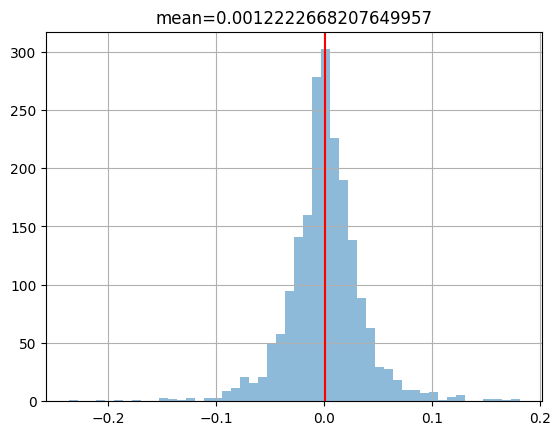

In [80]:
df['log_return'].hist(bins=50, alpha=.5)
mean = df['log_return'].mean()
plt.axvline(mean, c='red')
plt.title(f'{mean=}');

## Moving Average, Exponential Moving Average (MA, EMA)

<AxesSubplot: xlabel='Date'>

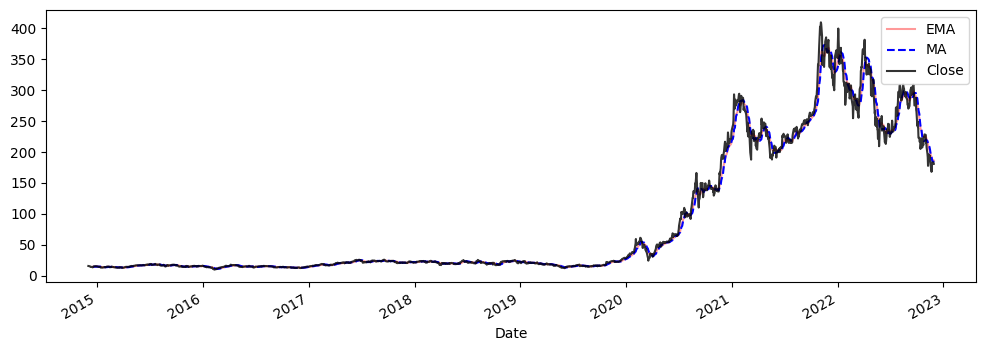

In [187]:
window = 14
df['MA'] = df['Close'].rolling(window).mean()
df['EMA'] = df['Close'].ewm(span=window, adjust=False, min_periods=window).mean()
# df['EMA'] = df['Close'].ewm(alpha=0.5).mean()

df['min'] = df['Close'].rolling(window).min()
df['max'] = df['Close'].rolling(window).max()

plt.figure(figsize=(12, 4))
df['EMA'].plot(style='-r', alpha=0.4, legend=True)
df['MA'].plot(style='--b', legend=True)
df['Close'].plot(c='black', alpha=0.8, legend=True)

## Moving Average Convergence Divergence (MACD)
+ https://www.learnpythonwithrune.org/pandas-calculate-the-moving-average-convergence-divergence-macd-for-a-stock/
+ https://www.alpharithms.com/calculate-macd-python-272222/

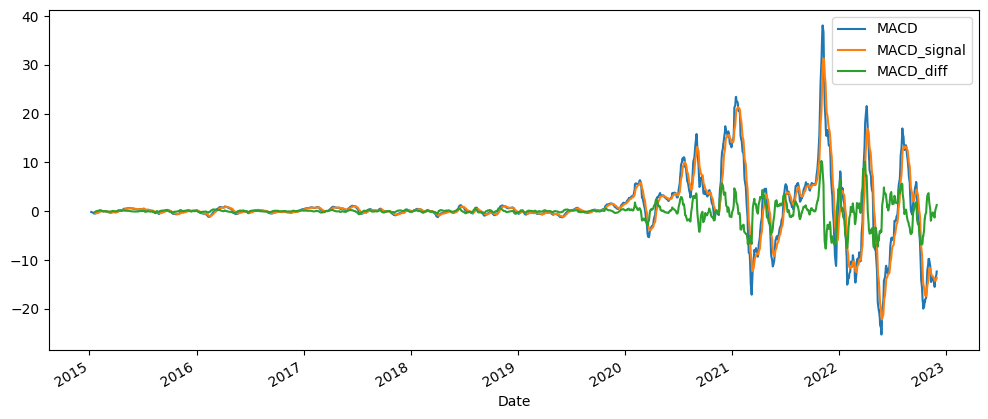

In [82]:
ewm_12 = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
ewm_26 = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
df['MACD'] = ewm_12 - ewm_26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False, min_periods=9).mean()
df['MACD_diff'] = df['MACD'] - df['MACD_signal']

plt.figure(figsize=(12, 5))
df['MACD'].plot(legend=True)
df['MACD_signal'].plot(legend=True)
df['MACD_diff'].plot(legend=True);

## RSI

+ https://medium.com/codex/algorithmic-trading-with-relative-strength-index-in-python-d969cf22dd85
+ https://www.learnpythonwithrune.org/pandas-calculate-the-relative-strength-index-rsi-on-a-stock/

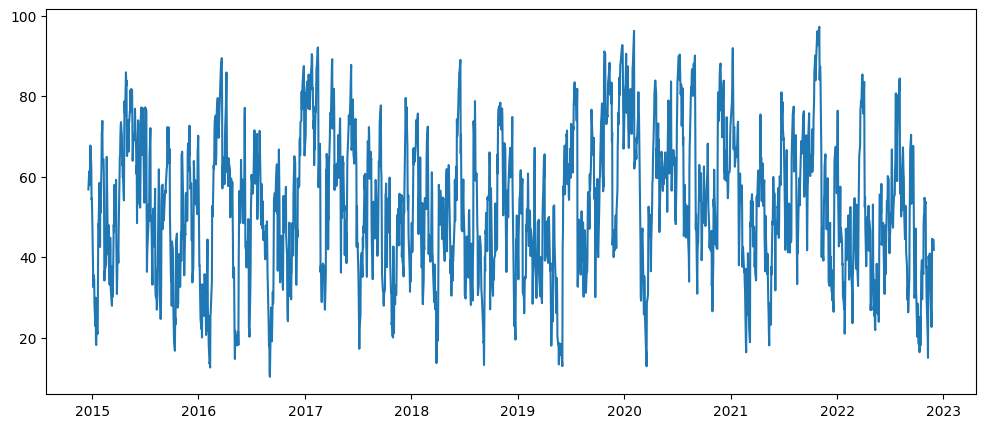

In [83]:
# com - дни в ретроспективе
def calculate_rsi(series, lookback):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = delta.clip(upper=0).abs()
    ema_up = up.ewm(span=lookback, adjust=False, min_periods=lookback).mean()
    ema_down = down.ewm(span=lookback, adjust=False, min_periods=lookback).mean()
    rs = ema_up/ema_down
    rsi = 100 - (100/(1 + rs))
    return rsi


df['RSI'] = calculate_rsi(df['Close'], 14)

plt.figure(figsize=(12, 5))
plt.plot(df['RSI']);

## Bollinger Bands

+ https://en.wikipedia.org/wiki/Bollinger_Bands
+ https://medium.com/codex/algorithmic-trading-with-bollinger-bands-in-python-1b0a00c9ef99

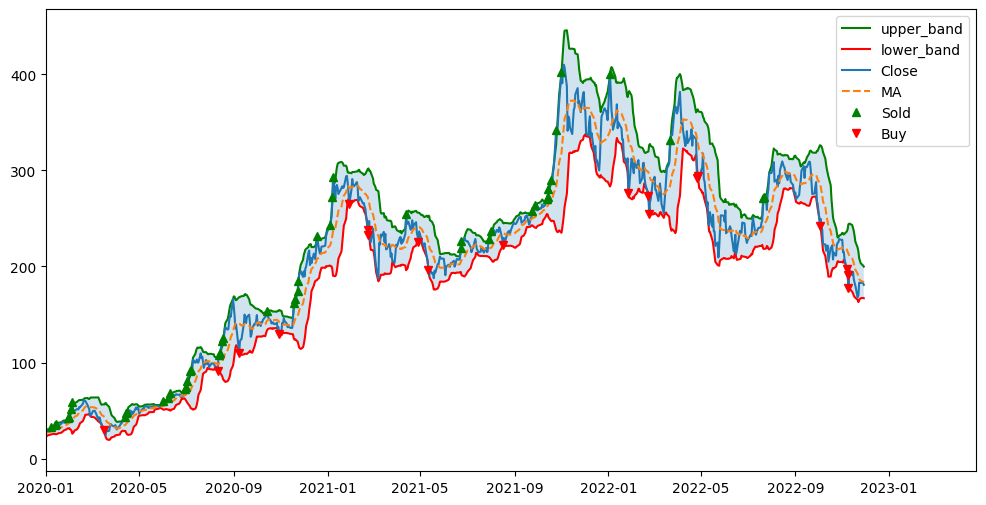

In [84]:
k = 2
std_20 = df['Close'].rolling(window).std()
std_ewm = df['Close'].ewm(span=window, adjust=False, min_periods=window).std()

df['upper_band'] = df['MA'] + k * std_20
df['lower_band'] = df['MA'] - k * std_20

plt.figure(figsize=(12, 6))
plt.plot(df['upper_band'], c='g', label='upper_band')
plt.plot(df['lower_band'], c='r', label='lower_band')
plt.plot(df['Close'], label='Close')
plt.plot(df['MA'], '--', label='MA')
plt.fill_between(df.index, df['upper_band'], df['lower_band'], alpha=0.2)

upper_point = df['Close'][df['Close'] > df['upper_band']]
lower_point = df['Close'][df['Close'] < df['lower_band']]
plt.plot(upper_point, 'g^', label='Sold')
plt.plot(lower_point, 'rv', label='Buy')
plt.xlim(pd.Timestamp('2020-01-01'))
plt.legend();

## Балансовый объём (OBV)
+ https://ru.wikipedia.org/wiki/%D0%91%D0%B0%D0%BB%D0%B0%D0%BD%D1%81%D0%BE%D0%B2%D1%8B%D0%B9_%D0%BE%D0%B1%D1%8A%D1%91%D0%BC

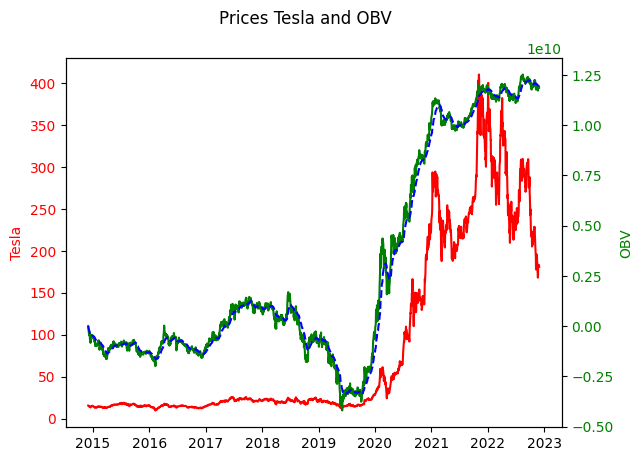

In [85]:
volumes = np.select(condlist=[df.Close.diff() > 0, df.Close.diff() < 0],
                    choicelist=[df.Volume, -df.Volume])

df['OBV'] = volumes.cumsum()

fig, ax1 = plt.subplots()
fig.suptitle('Prices Tesla and OBV')

ax1.plot(df['Close'], color='red')
ax1.set_ylabel('Tesla', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(df['OBV'], color='green')
ax2.plot(df['OBV'].ewm(com=13).mean(), '--b')
ax2.set_ylabel('OBV', color='green')
ax2.tick_params(axis='y', labelcolor='green')

## Chaikin Money Flow (CMF)
+ https://corporatefinanceinstitute.com/resources/equities/chaikin-money-flow-cmf/
+ https://stackoverflow.com/questions/64124629/how-to-calculate-heiken-chaiken-osc-using-pandas-python
+ https://medium.com/swlh/creating-a-trading-strategy-from-scratch-in-python-fe047cb8f12

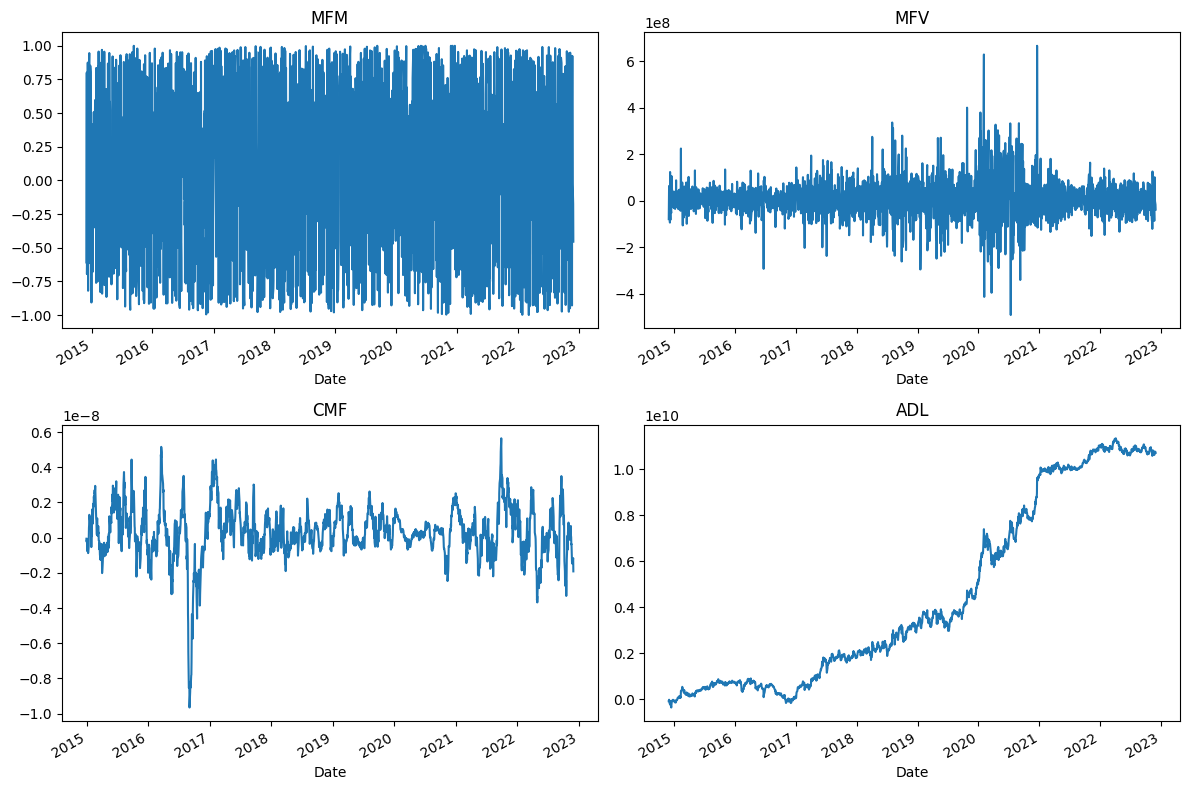

In [86]:
df['MFM'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
df['MFV'] = df['MFM'] * df['Volume']
df['CMF'] = df['MFM'].rolling(21).mean() / df['Volume'].rolling(21).mean()
df['ADL'] =  df['MFV'].cumsum()

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
df['MFM'].plot(ax=ax[0, 0], title='MFM')
df['MFV'].plot(ax=ax[0, 1], title='MFV')
df['CMF'].plot(ax=ax[1, 0], title='CMF')
df['ADL'].plot(ax=ax[1, 1], title='ADL')
plt.tight_layout()

In [40]:
df.describe()

,High,Low,Open,Volume,Close,SP500,VWAP,Diff_closes,rise,ATR,+DM,-DM,+DI,-DI,ADX,simple_return,log_return,log_return_square,volatility_30,volatility_60,volatility_100,MA,EMA,MACD,MACD_signal,MACD_diff,RSI,upper_band,lower_band,OBV,MFM,MFV,CMF,ADL
count,2014.000000,2014.000000,2014.000000,2.014000e+03,2014.000000,2014.000000,2014.000000,2013.000000,2014.000000,2001.000000,2014.000000,2014.000000,2001.000000,2001.000000,1987.000000,2013.000000,2013.000000,2013.000000,1984.000000,1954.000000,1914.000000,2001.000000,2001.000000,1989.000000,1981.000000,1981.000000,2000.000000,2001.000000,2001.000000,2.014000e+03,2014.000000,2.014000e+03,1.994000e+03,2.014000e+03
mean,89.143745,85.036166,87.186896,1.108208e+08,87.129728,279.694186,28.185483,0.082160,0.516385,4.471364,1.104996,1.076238,25.796939,22.835442,34.802419,0.001848,0.001222,0.001251,0.178835,0.257089,0.336163,87.059133,87.044139,0.674996,0.705791,-0.026885,53.130093,96.541342,77.576925,2.868636e+09,0.033534,5.321993e+06,2.930781e-10,4.482267e+09
std,111.220535,105.880646,108.714414,8.017940e+07,108.565797,87.705582,19.605671,5.455207,0.499856,6.109417,3.406510,3.399203,12.984620,11.305880,14.147831,0.035410,0.035360,0.003298,0.075188,0.096675,0.117032,108.394663,108.214565,6.163465,5.772147,1.877674,17.513776,120.747047,96.556896,5.274376e+09,0.615400,8.519099e+07,1.501128e-09,4.003492e+09
min,10.331333,9.403333,9.488000,1.062000e+07,9.578000,161.966263,13.696286,-46.480011,0.000000,0.256238,-8.020020,-6.333344,1.449591,-0.513674,9.763366,-0.210628,-0.236518,0.000000,0.064647,0.121981,0.174827,10.785619,11.070764,-25.271333,-22.213158,-7.678481,10.304821,12.396554,8.681395,-4.199914e+09,-0.999676,-4.910729e+08,-9.654679e-09,-3.526304e+08
25%,16.255666,15.706833,15.985166,6.293512e+07,16.012832,198.429417,14.989717,-0.414000,0.000000,0.573762,0.000000,0.000000,16.909614,14.492528,24.214232,-0.014929,-0.015041,0.000050,0.123991,0.179663,0.236949,16.001524,15.971433,-0.365129,-0.328286,-0.171870,40.391993,17.191100,14.728555,-9.980194e+08,-0.515983,-4.071563e+07,-4.325151e-10,7.365987e+08
50%,21.835334,21.108000,21.531000,8.707555e+07,21.571000,259.875763,18.201963,0.023333,1.000000,0.815048,0.000000,0.000000,23.532362,21.841368,31.436578,0.001210,0.001209,0.000293,0.158899,0.241784,0.308995,21.733953,21.780621,0.097053,0.103994,0.011674,52.934607,23.690054,19.854333,3.466552e+08,0.030473,1.918142e+06,2.656790e-10,3.129116e+09
75%,184.797501,174.674995,178.932507,1.263690e+08,179.540001,353.163277,35.826342,0.503334,1.000000,7.346189,0.409500,0.333329,31.989149,30.374004,42.829565,0.018706,0.018533,0.001042,0.215692,0.311440,0.419450,173.458810,177.549716,1.049551,0.986213,0.186727,65.327802,206.893371,135.997459,9.027574e+09,0.605789,5.018706e+07,1.095247e-09,8.281906e+09
max,414.496674,405.666656,411.470001,9.140820e+08,409.970001,472.242310,79.224617,47.666656,1.000000,24.814054,45.006653,40.493317,107.397798,75.129670,88.084638,0.198949,0.181445,0.055941,0.478978,0.621724,0.673493,373.069046,368.666572,38.067930,31.285426,10.296174,97.253740,445.803398,337.513162,1.252184e+10,1.000000,6.663786e+08,5.648008e-09,1.135228e+10


## Время

In [87]:
# df['month'] = df.index.month_name()
df['month'] = df.index.month
# df['day'] = df.index.day_name()
df['day'] = df.index.day
df['year'] = df.index.year
df['quarter'] = df.index.quarter

<AxesSubplot: xlabel='year', ylabel='Close'>

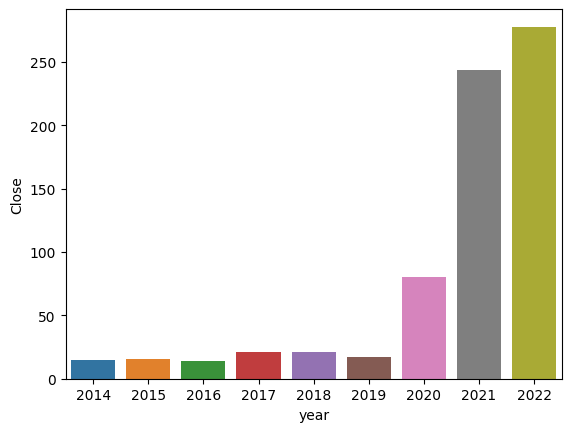

In [88]:
df_year = df.groupby(['year'], as_index=False)[['Close']].median()
sns.barplot(data=df_year, x='year', y='Close')

<AxesSubplot: xlabel='month', ylabel='Close'>

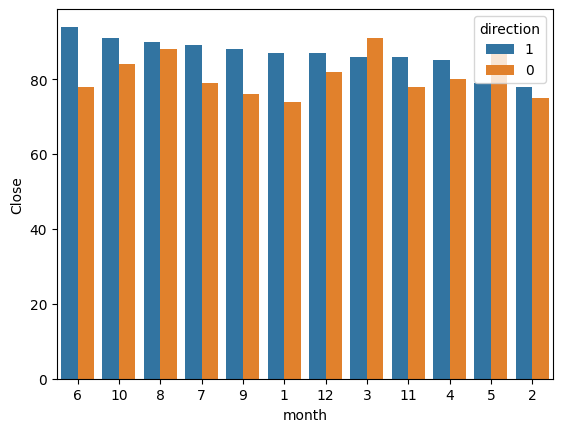

In [90]:
df_month = df.groupby(['month', 'direction'], as_index=False)[['Close']].count()
df_sort = df_month.sort_values(['direction', 'Close'], ascending=False)
df_sort = df_sort[df_sort['direction'] == 1]
sns.barplot(data=df_month, x="month", y="Close", hue="direction", order=df_sort['month'].tolist(), hue_order=[1, 0])

<AxesSubplot: xlabel='day', ylabel='Close'>

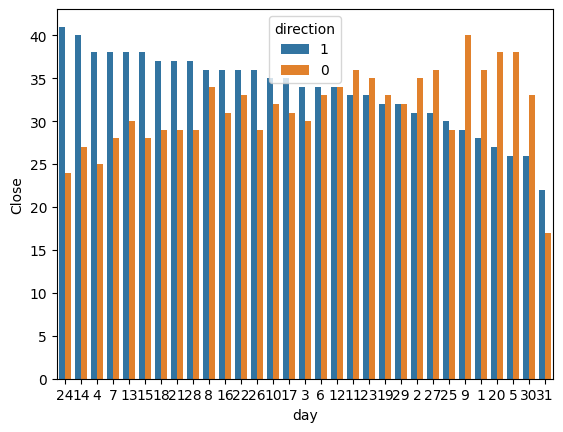

In [91]:
df_day = df.groupby(['day', 'direction'], as_index=False)[['Close']].count()
df_sort = df_day.sort_values(['direction', 'Close'], ascending=False)
df_sort = df_sort[df_sort['direction'] == 1]
sns.barplot(data=df_day, x="day", y="Close", hue="direction", order=df_sort['day'].tolist(), hue_order=[1, 0])

<AxesSubplot: xlabel='quarter', ylabel='Close'>

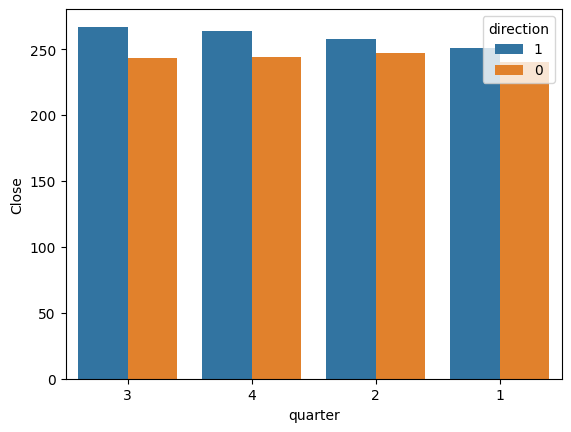

In [92]:
df_quarter = df.groupby(['quarter', 'direction'], as_index=False)[['Close']].count().sort_values(['direction', 'Close'])
sns.barplot(data=df_quarter, x="quarter", y="Close", hue="direction", order=[3, 4, 2, 1], hue_order=[1, 0])

<AxesSubplot: xlabel='month', ylabel='log_return'>

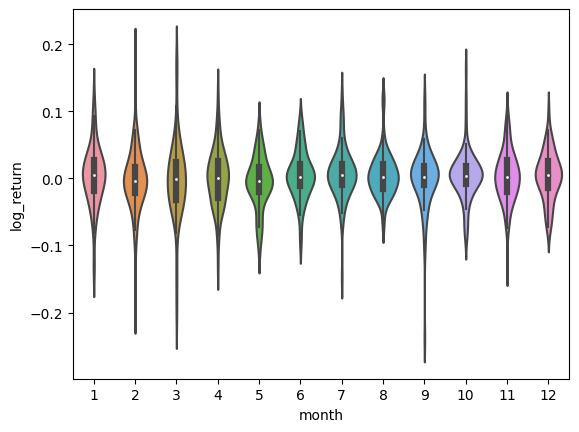

In [93]:
sns.violinplot(data=df.iloc[-1000:], x="month", y="log_return")

<AxesSubplot: xlabel='day', ylabel='log_return'>

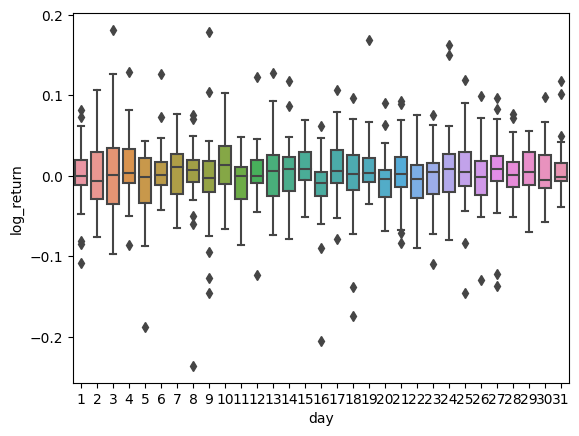

In [94]:
sns.boxplot(data=df.iloc[-1000:], x="day", y="log_return")

## Корреляция

<AxesSubplot: >

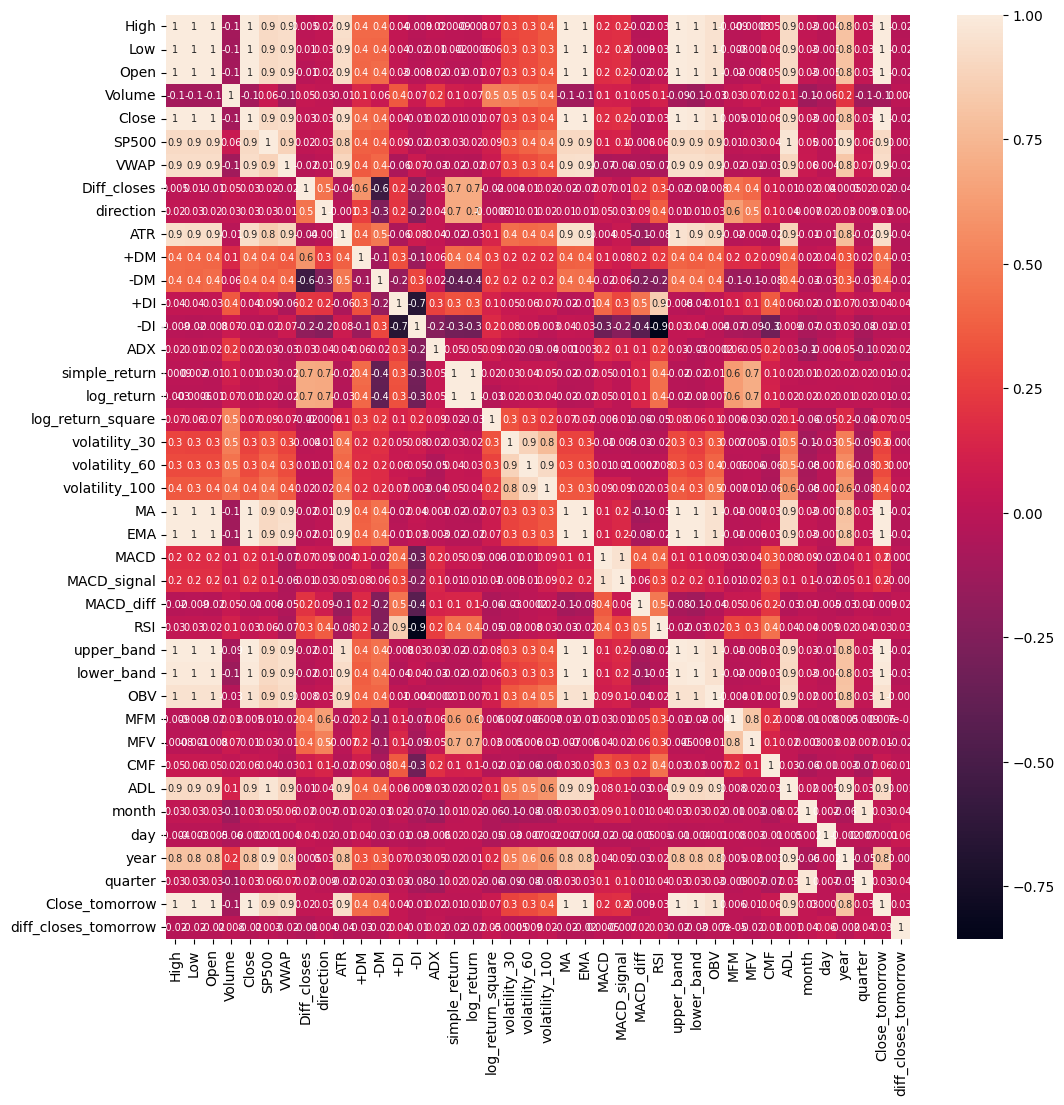

In [95]:
df['Close_tomorrow'] = df['Close'].shift(-1)
df['diff_closes_tomorrow'] = df['Diff_closes'].shift(-1)
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr().dropna(), annot=True, annot_kws={'fontsize': 7}, fmt='.1g')

## Автокорреляция

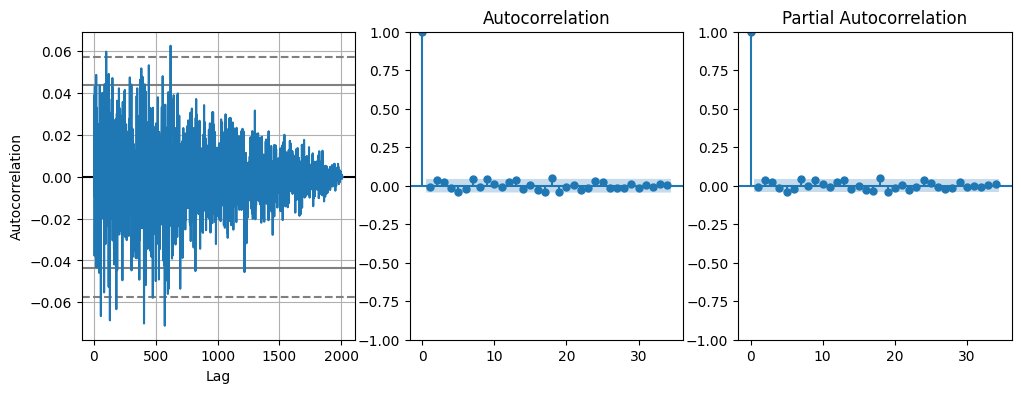

In [96]:
df_acorr = df['log_return'].dropna()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
pd.plotting.autocorrelation_plot(df_acorr, ax=axes[0])
plot_acf(df_acorr, ax=axes[1])
plot_pacf(df_acorr, method='ywm', ax=axes[2]);

## Фурье

+ https://towardsdatascience.com/fourier-transform-for-time-series-292eb887b101
+ https://www.programmersought.com/article/37555505916/

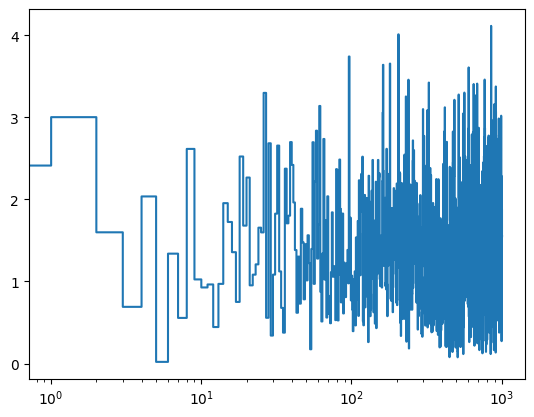

In [97]:
fft = tf.signal.rfft(df['log_return'].dropna())
f_per_dataset = np.arange(0, len(fft))
# plt.plot(np.abs(fft))

plt.step(f_per_dataset, np.abs(fft))
plt.xscale('log')
# plt.xlabel('Frequency (log scale)')

## Отбор признаков

<BarContainer object of 44 artists>

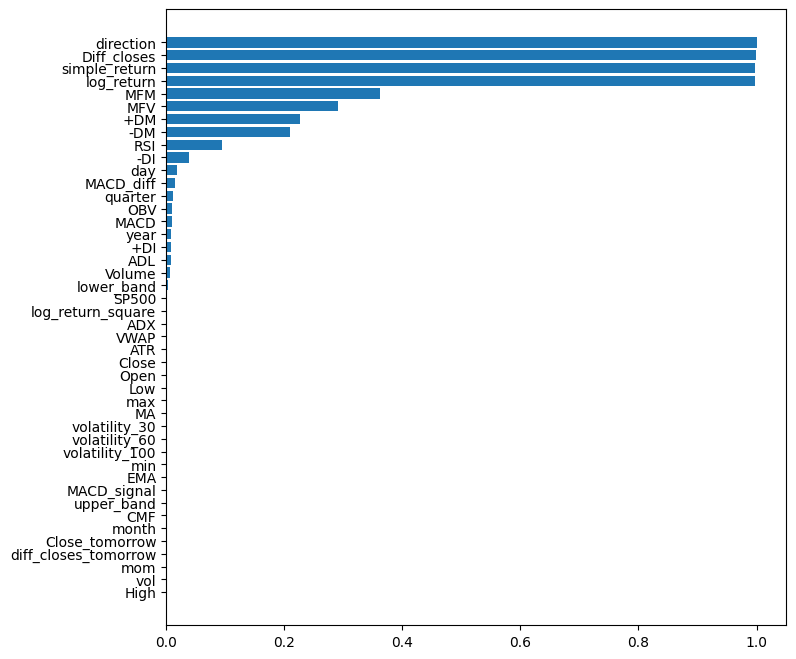

In [219]:
target = 'direction'

df_mi = df.copy()
columns_mi = df_mi.columns
df_mi['target'] = df_mi[target].shift(-1)
df_mi = df_mi.dropna()
mi = mutual_info_classif(df_mi[columns_mi], df_mi[target])
mi /= mi.max()

indexes = mi.argsort()

plt.figure(figsize=(8, 8))
plt.barh(columns_mi[indexes], mi[indexes])

In [220]:
selected = indexes[mi[indexes] > .0]
columns_mi[selected]

Index(['log_return_square', 'SP500', 'lower_band', 'Volume', 'ADL', '+DI',
       'year', 'MACD', 'OBV', 'quarter', 'MACD_diff', 'day', '-DI', 'RSI',
       '-DM', '+DM', 'MFV', 'MFM', 'log_return', 'simple_return',
       'Diff_closes', 'direction'],
      dtype='object')

In [107]:
selected

array([17,  5, 28,  3, 33, 12, 23, 29, 25, 32, 13, 26, 11, 10, 31, 30, 16,
       15,  7,  8], dtype=int64)

## Распределения данных

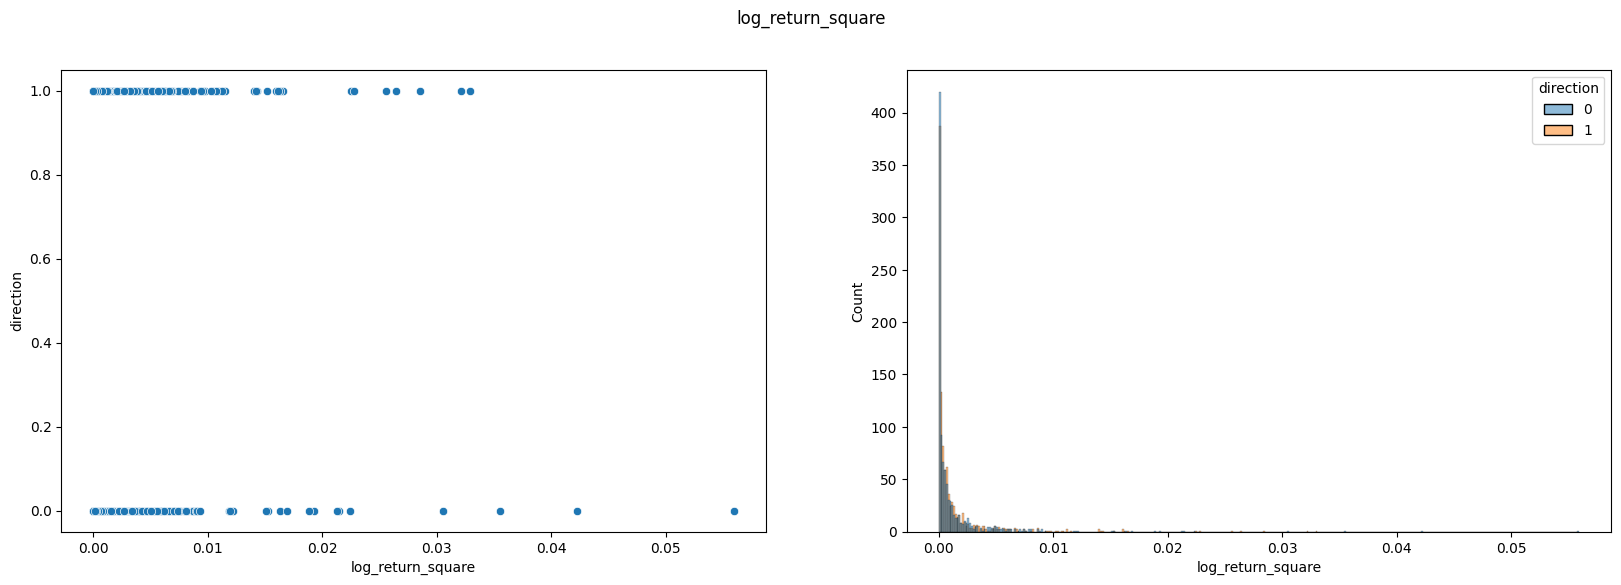

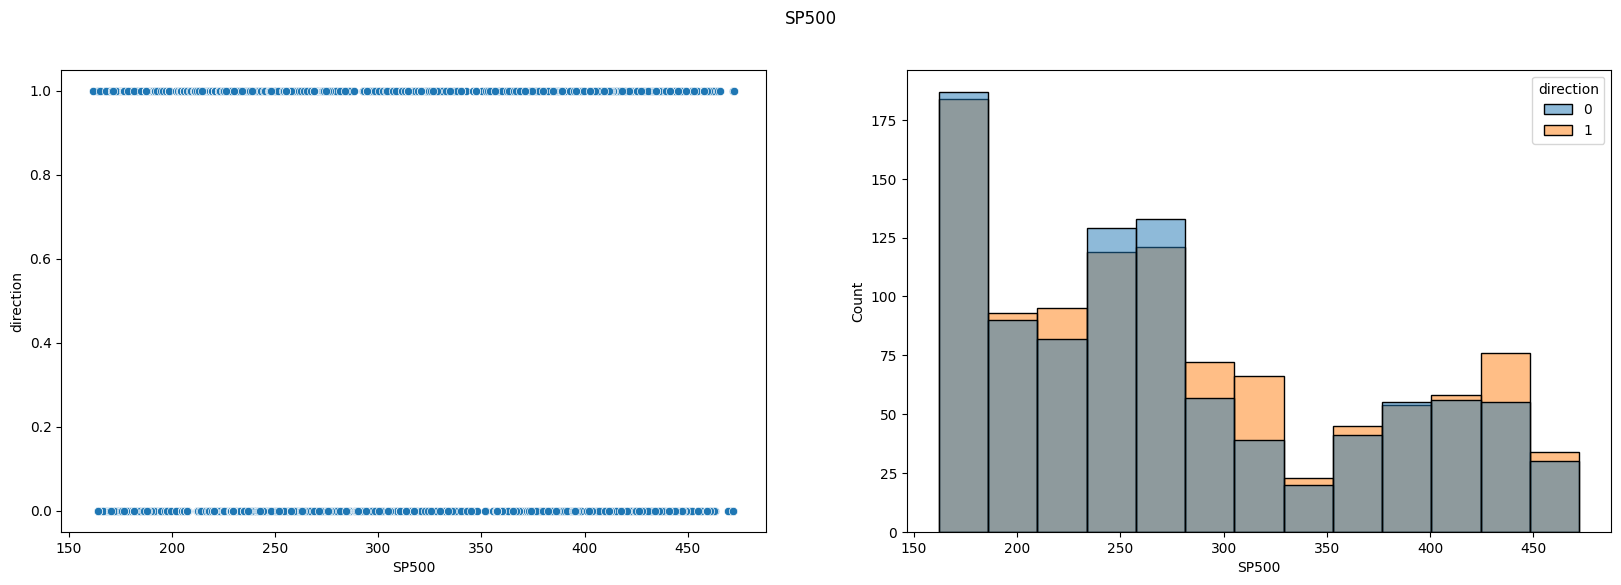

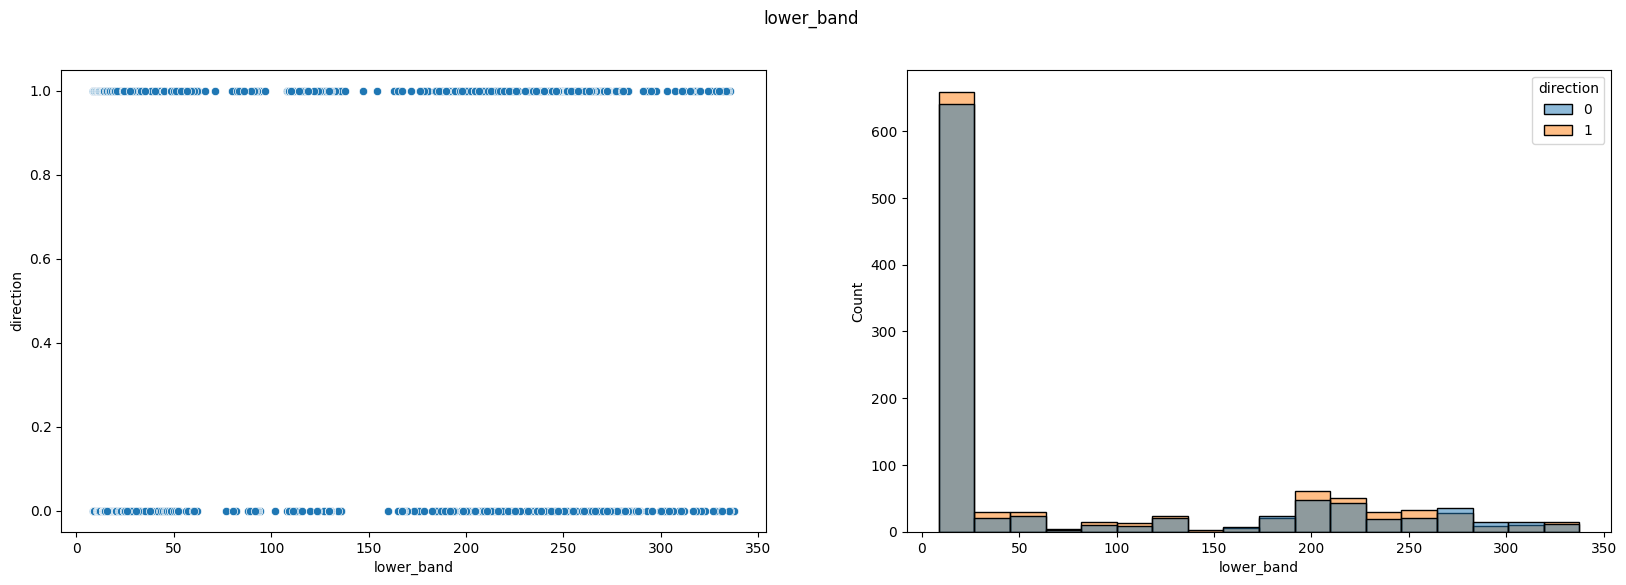

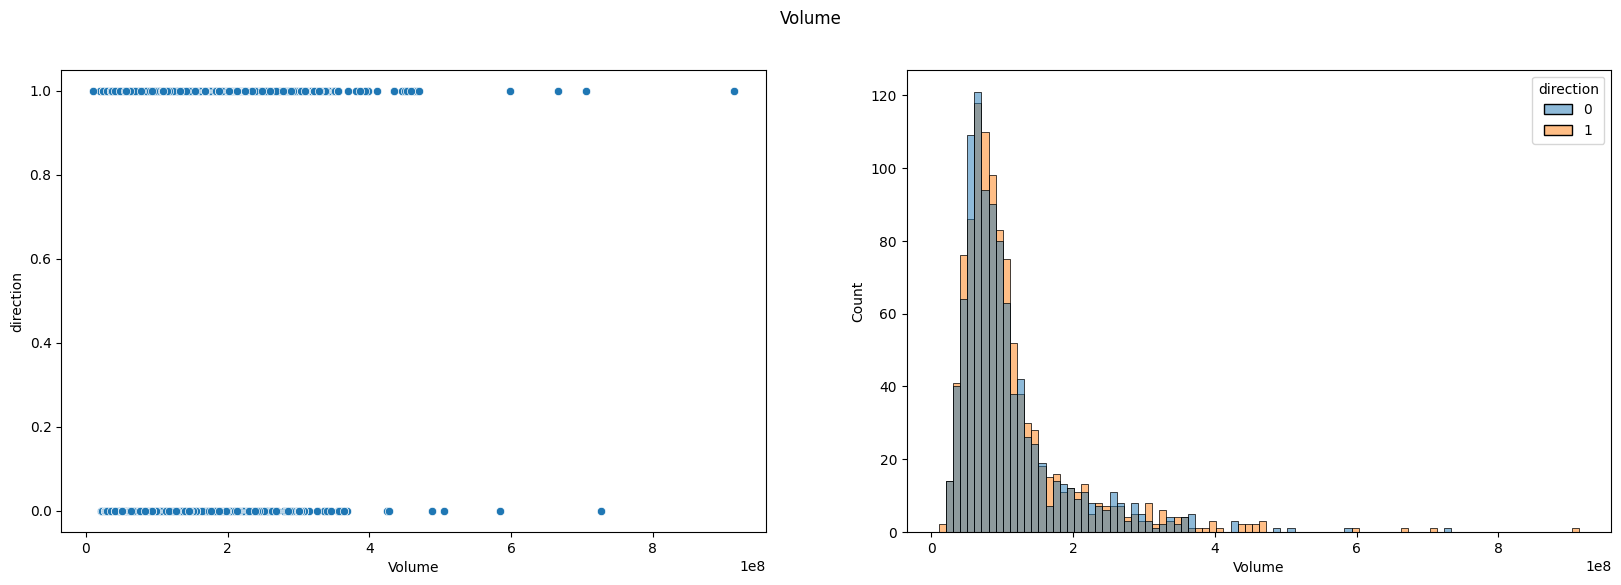

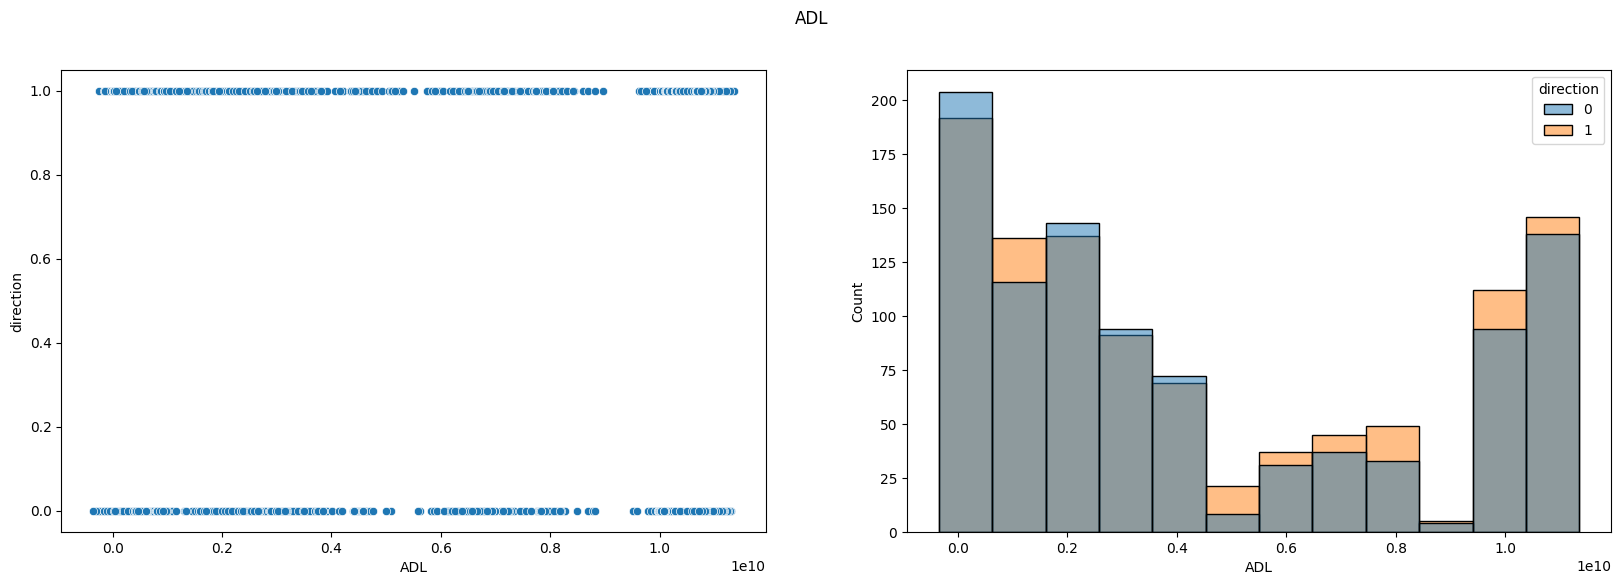

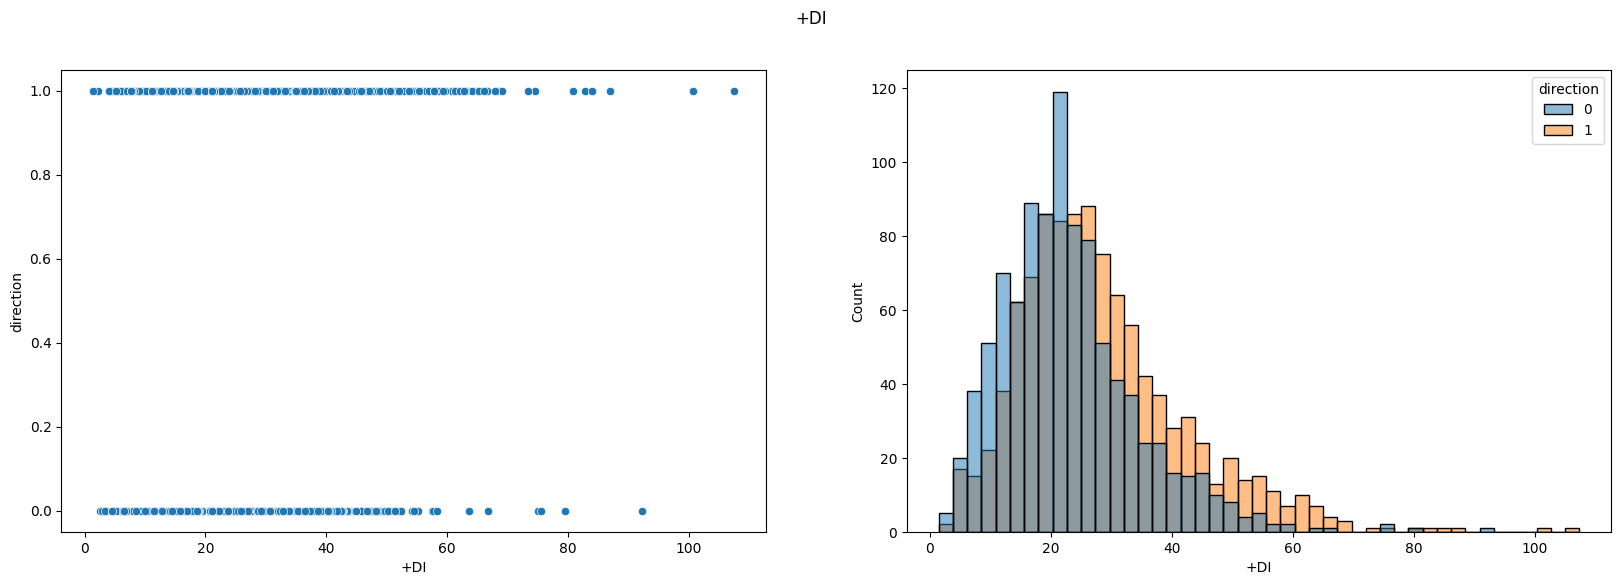

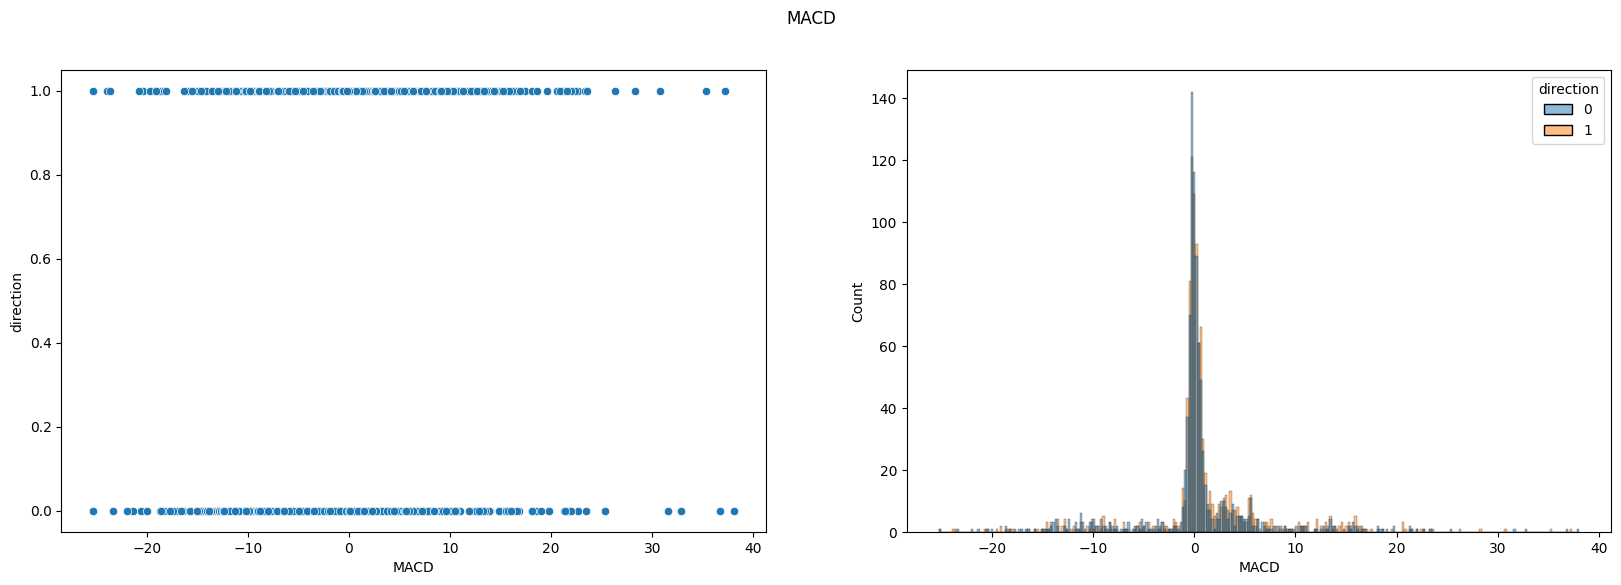

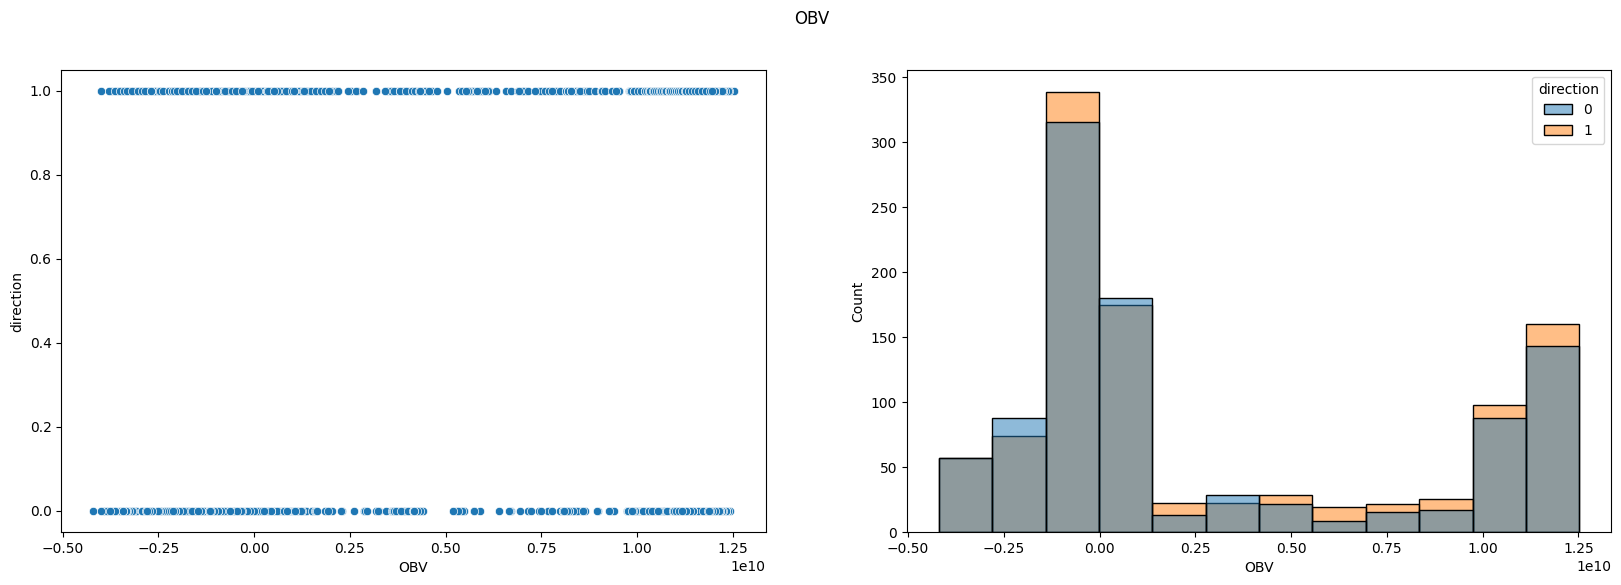

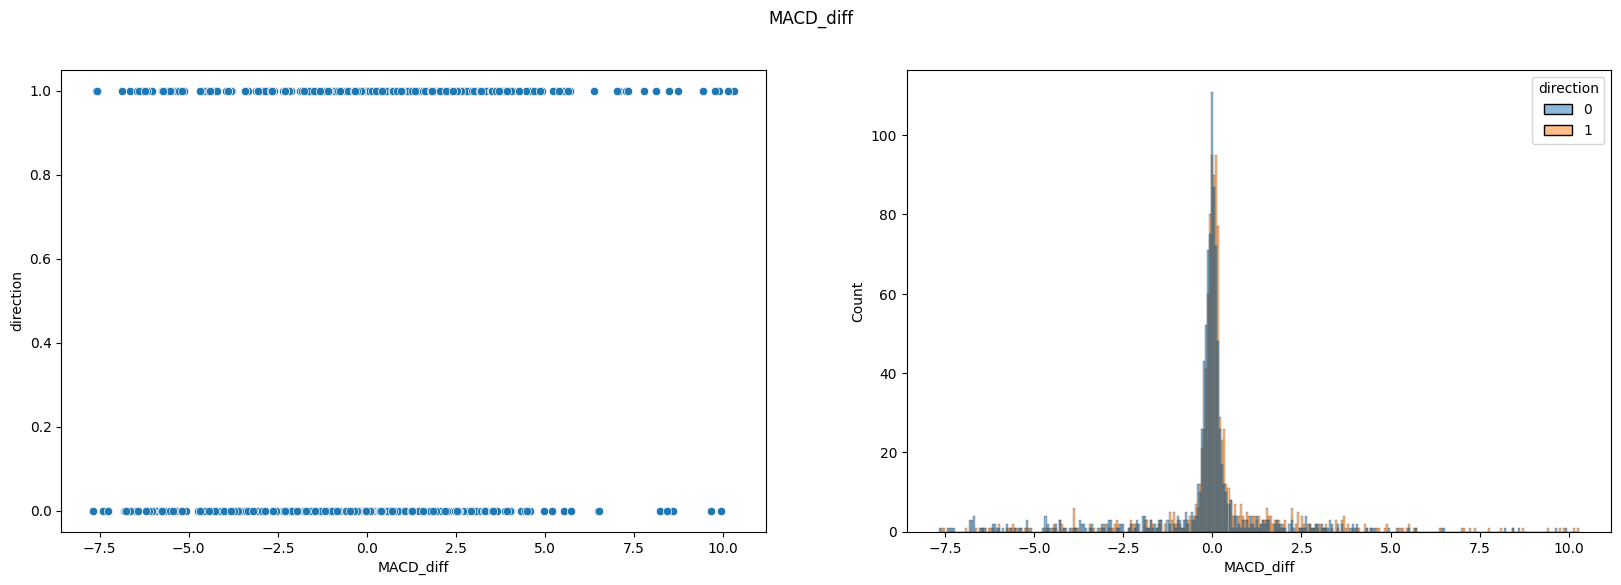

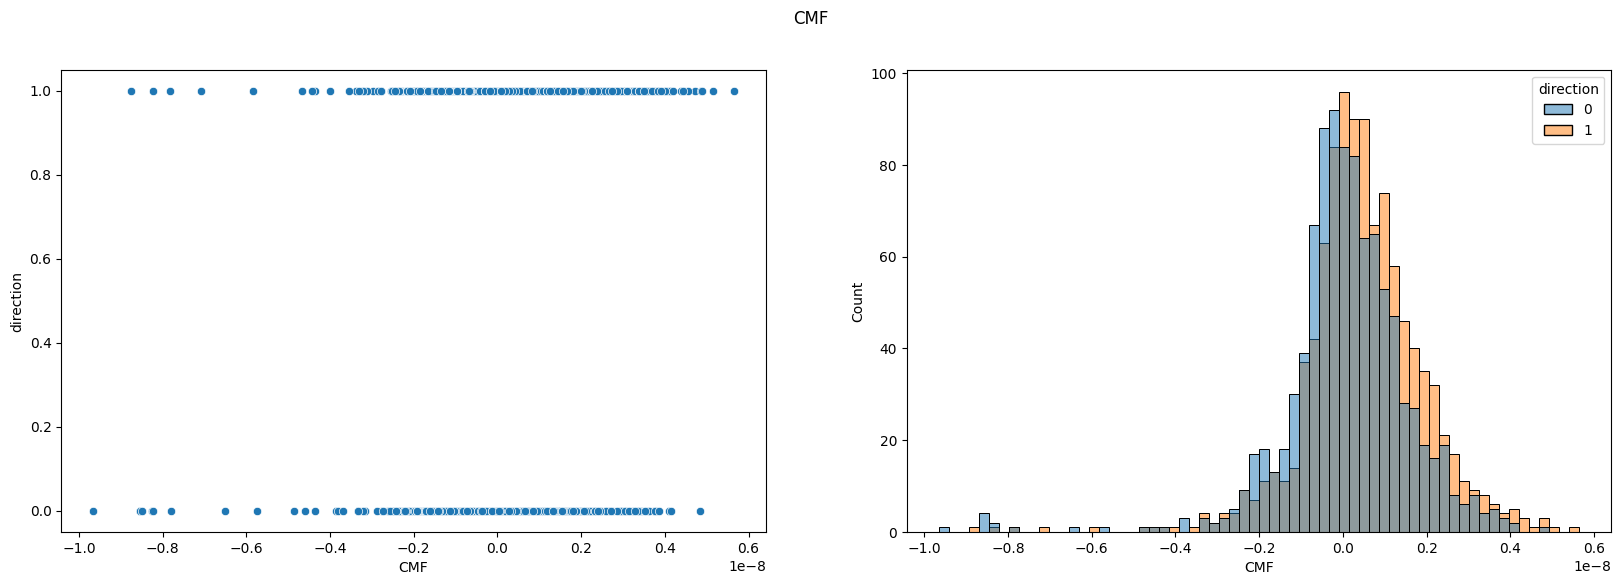

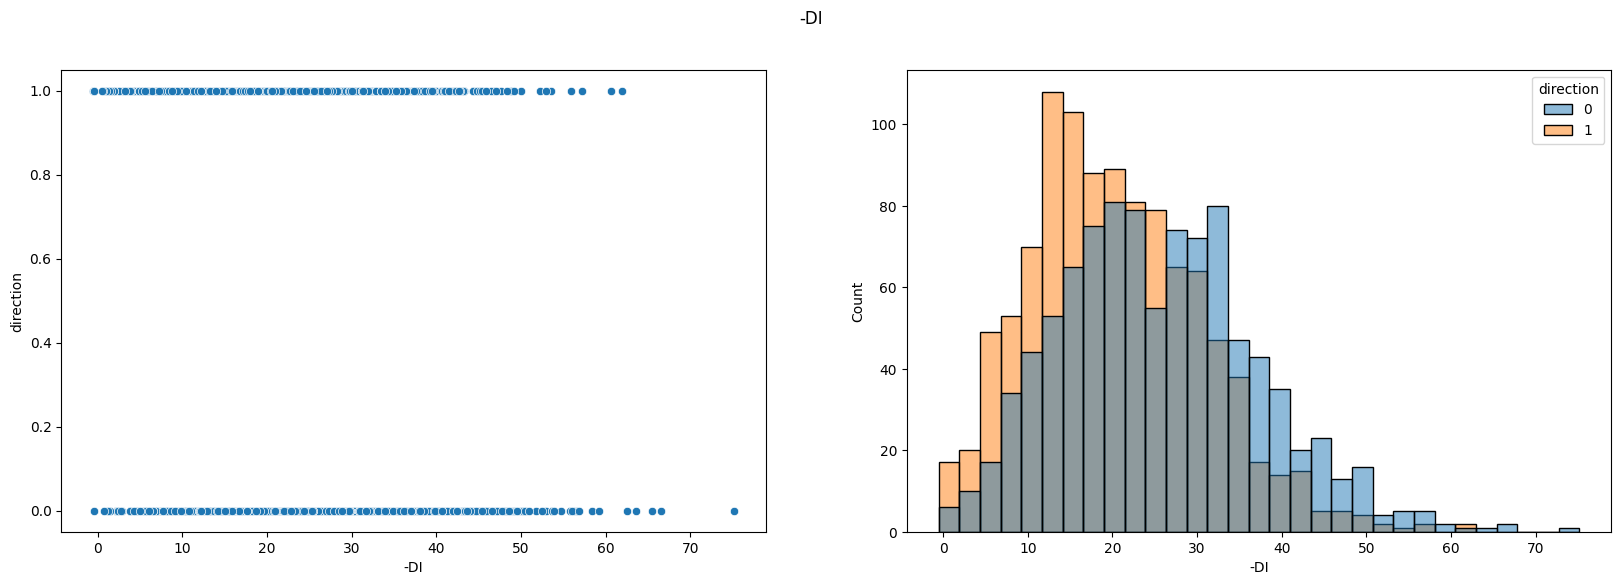

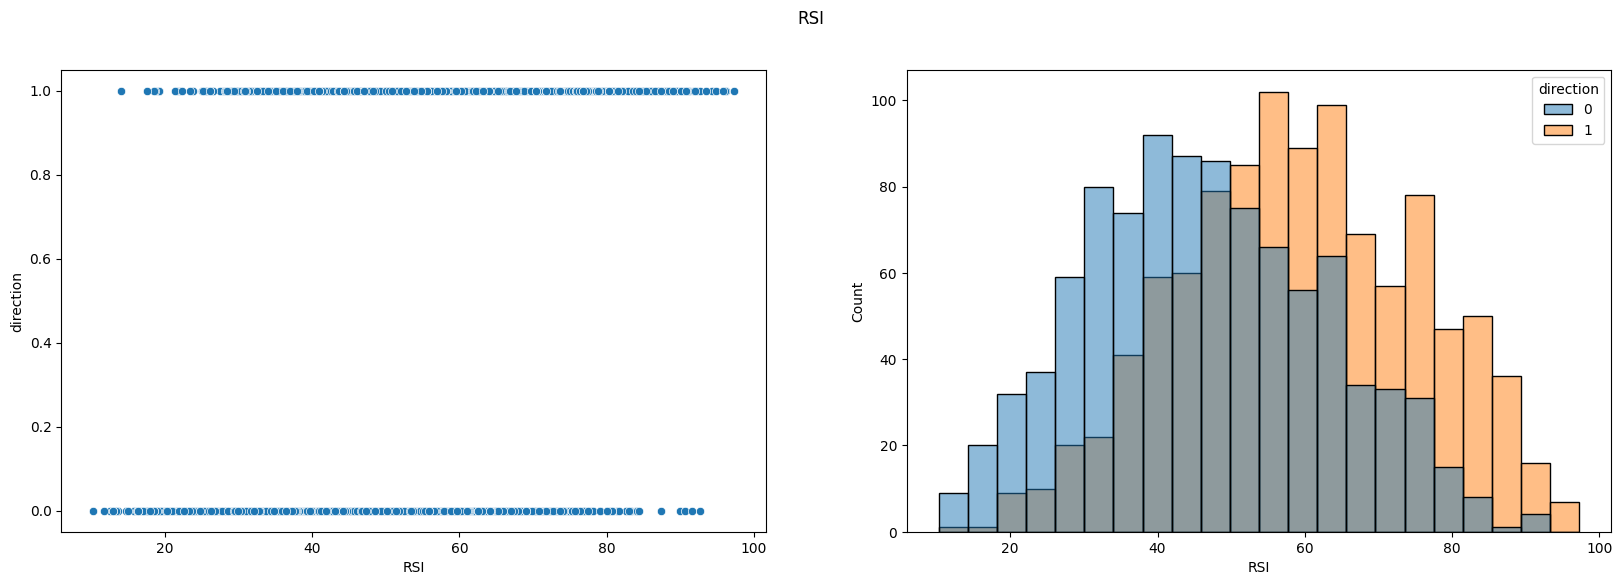

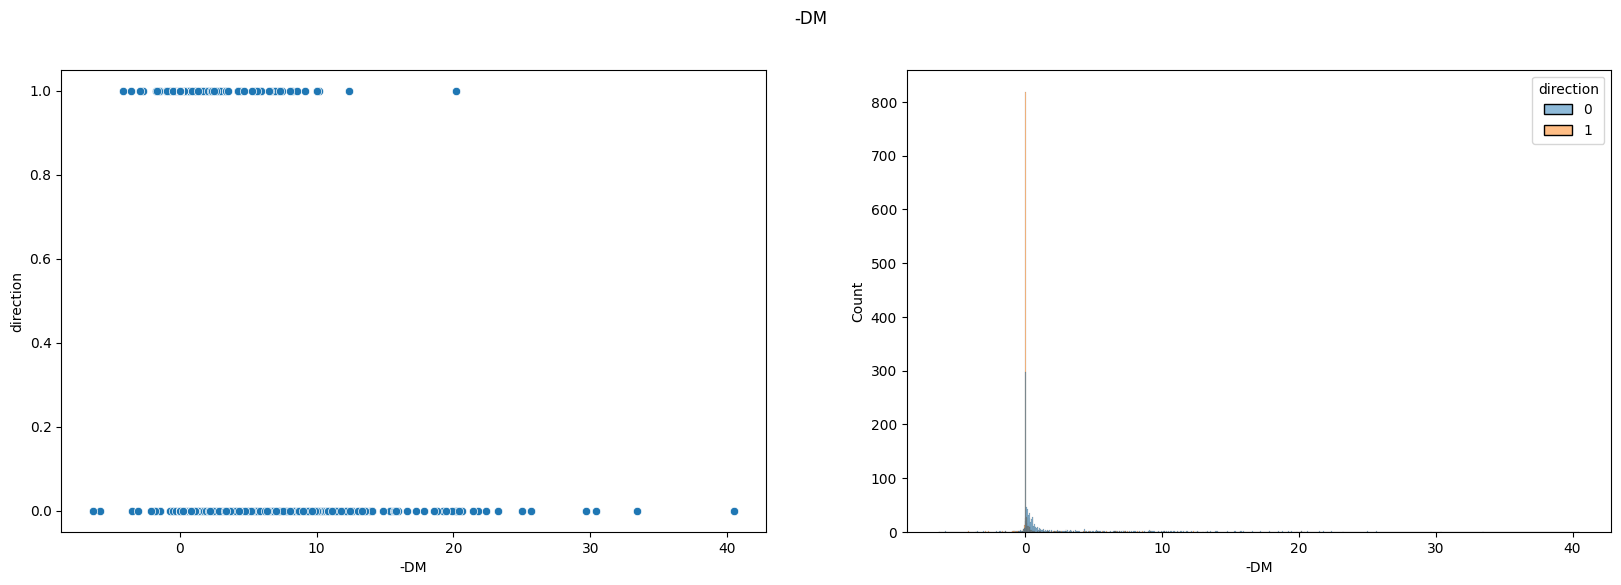

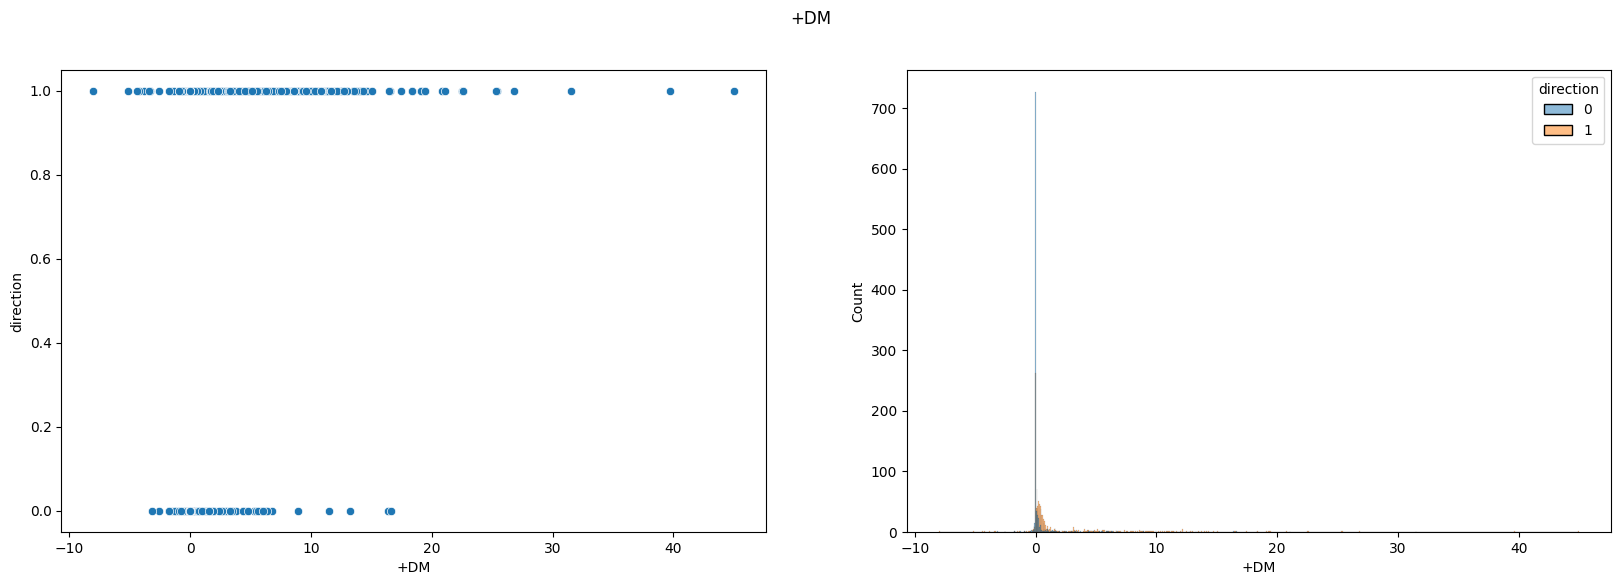

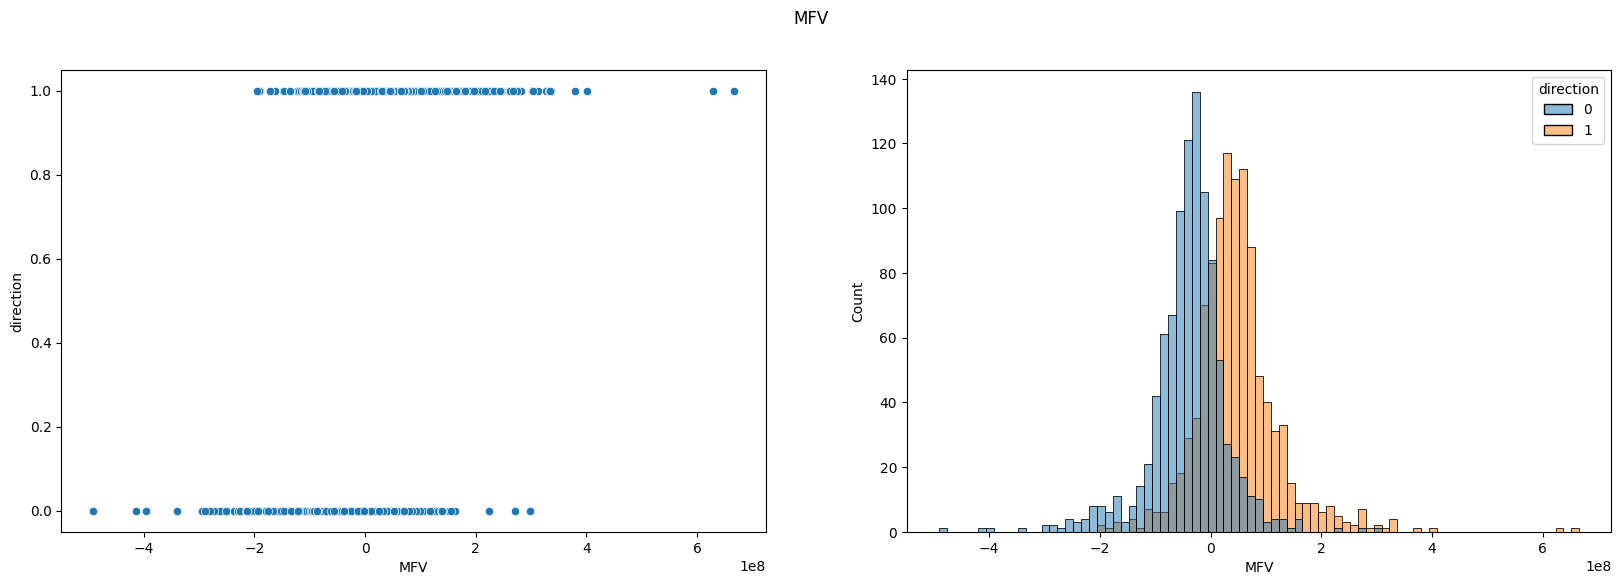

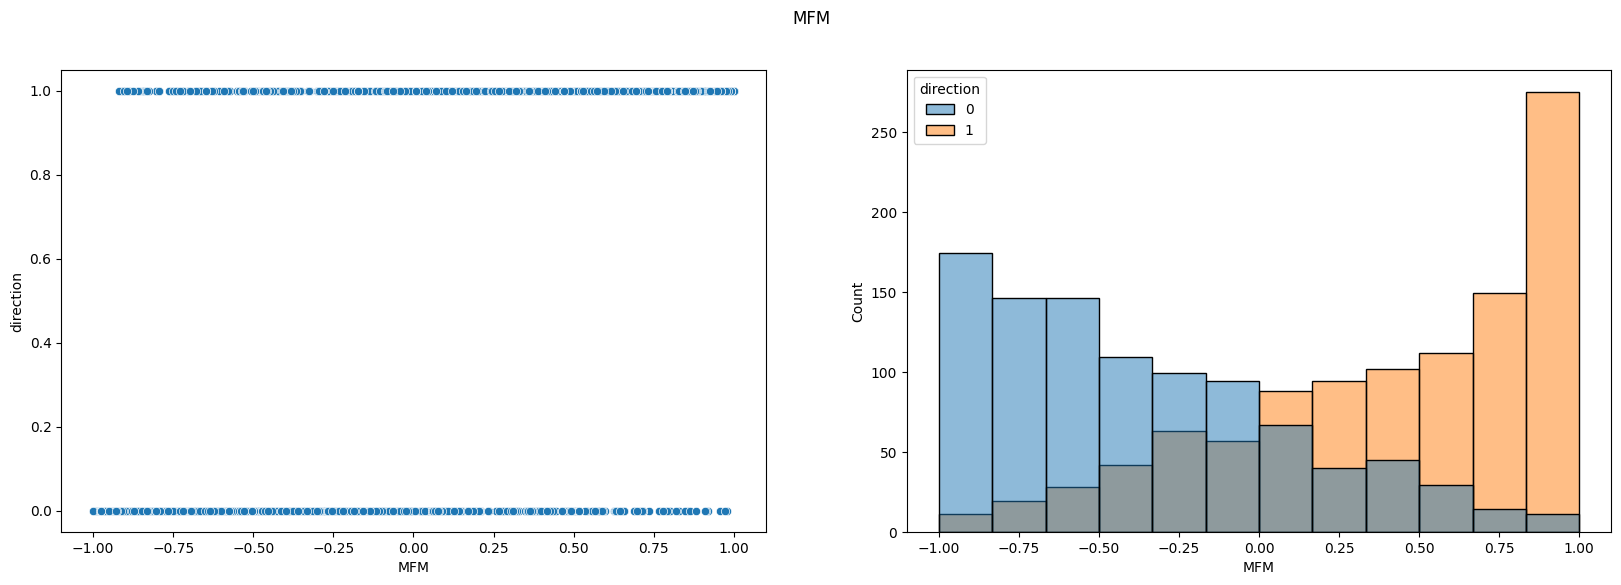

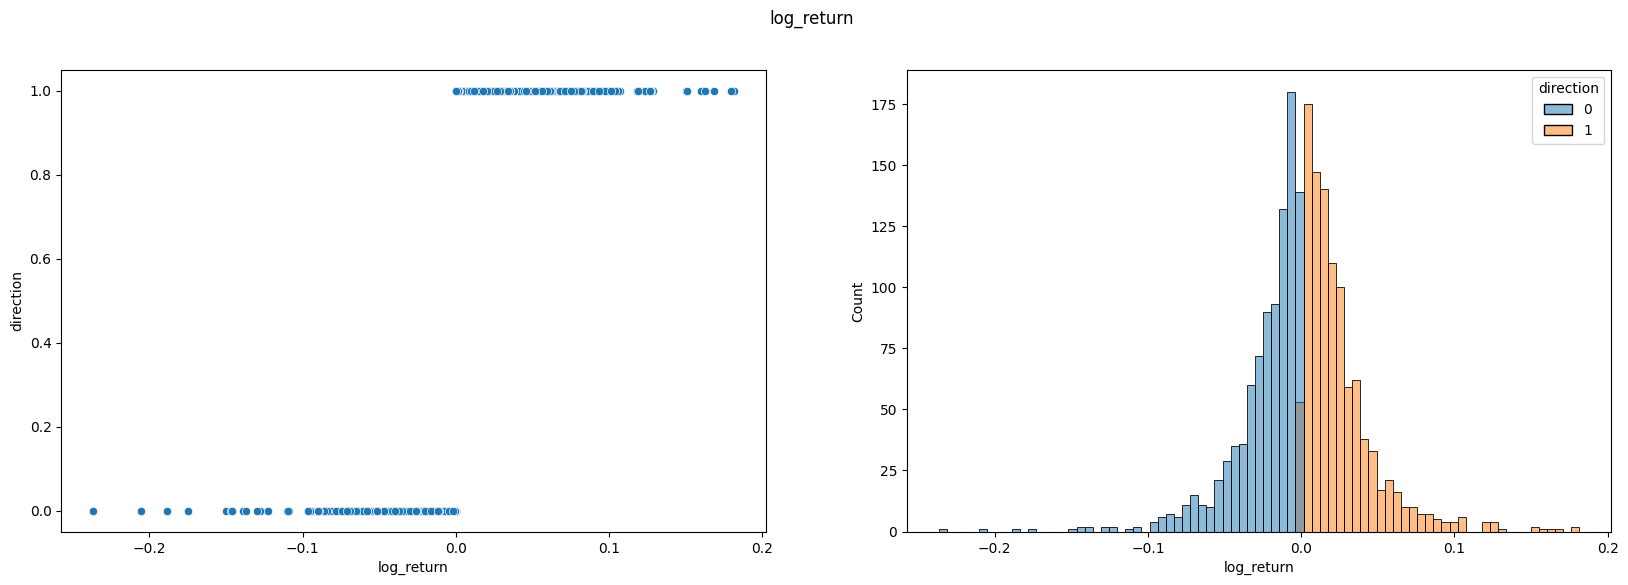

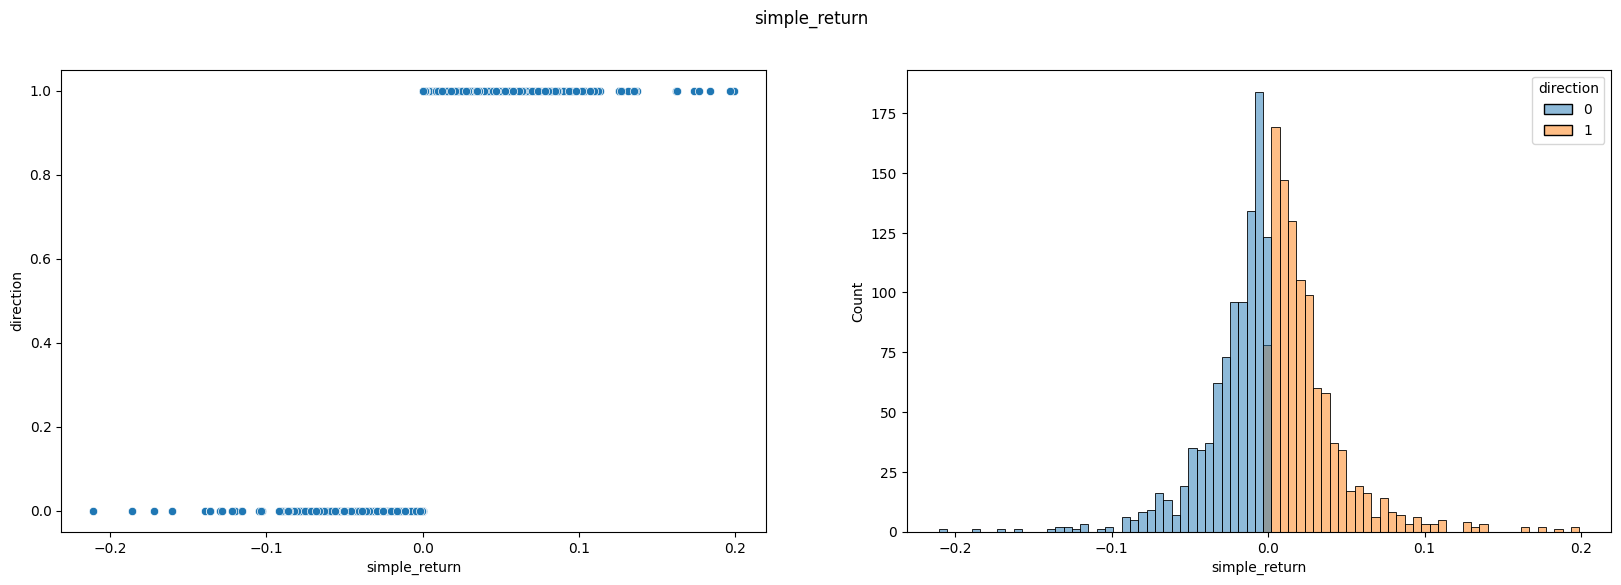

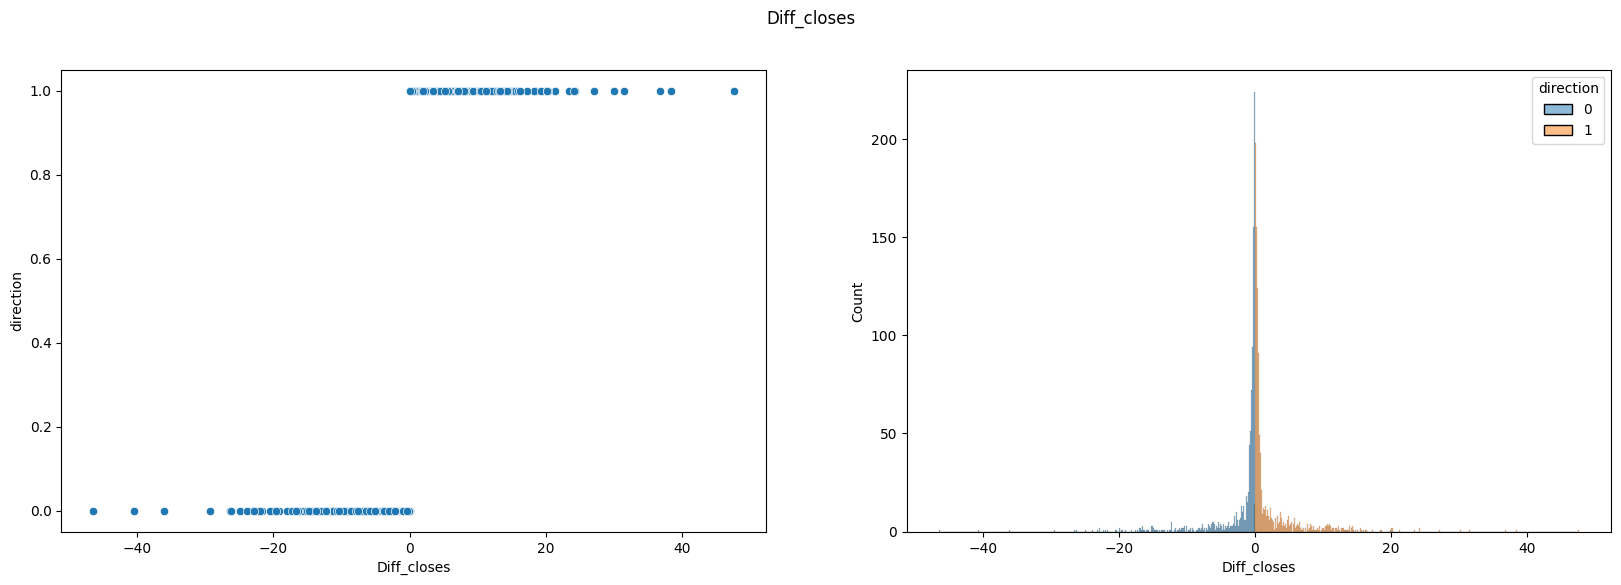

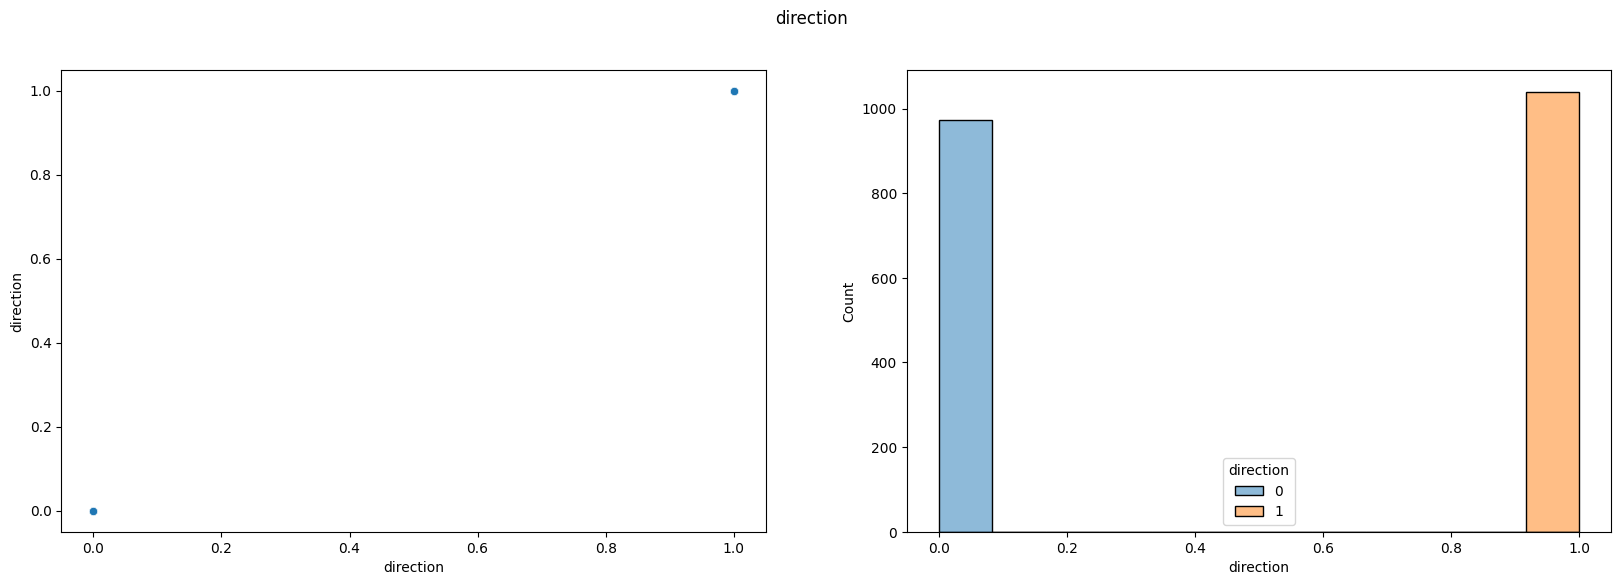

In [108]:
columns = columns_mi[selected]
target_column = 'direction'
hue = 'direction'
target = df[target_column]
for feature in columns:
    df_feature = df[feature]
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(feature)
    sns.scatterplot(data=df, x=feature, y=target_column, ax=ax[0])
    ax[0].set_xlabel(feature)
    ax[0].set_ylabel(target_column)
#     ax[1].hist(df[feature], bins=30);
    sns.histplot(data=df, x=feature, ax=ax[1], hue=target_column)
    ax[1].set_xlabel(feature)

# Моделирование
+ https://medium.com/analytics-vidhya/analysis-of-stock-price-predictions-using-lstm-models-f993faa524c4
+ https://github.com/miracl1e6/Tesla-Stock-Price/blob/master/tesla-stock-price-prediction-lstm-vs-gru-2.ipynb
+ https://www.tensorflow.org/tutorials/structured_data/time_series
+ https://habr.com/ru/post/701798/
+ https://habr.com/ru/post/527334/
+ https://www.datacamp.com/tutorial/lstm-python-stock-market
+ https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network#!&_escaped_fragment_=

## Метрики

In [116]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [117]:
def calculate_metrics(y_real, y_predict):
    assert len(y_real) == len(
        y_predict), "y_real и y_predict имеют разное кол-во примеров"
    acc = accuracy_score(y_real, y_predict)
    f1 = f1_score(y_real, y_predict)
    roc_auc = roc_auc_score(y_real, y_predict)
    return acc, f1, roc_auc


def print_metrics(metrics, metrics_names):
    print(*(f'{name}: {value}' for name,
          value in zip(metrics_names, metrics)), sep='\n')


def add_results(df_results, metrics, model_name):
    data = [[model_name] + list(metrics)]
    df_model = pd.DataFrame(data=data, columns=df_results.columns)
    df_results = pd.concat([df_results, df_model], axis=0).drop_duplicates(
        subset=df_results.columns[0], keep='last', ignore_index=True)
    return df_results


def plot_predicted_points(y_predict, y_real):
    plt.figure(figsize=(12, 5))
    plt.plot(y_predict, label='predict', alpha=.7)
    plt.plot(y_real, label='real', alpha=.7)
    plt.xlabel('День')
    plt.ylabel('Цена')
    plt.title('Предсказания цены акции')
    plt.legend()

In [289]:
# Подготовка метрик для сравнения результатов
metrics_names = ['ACC', 'F1', 'ROC-AUC']
columns = ['model'] + metrics_names
df_results = pd.DataFrame(columns=columns)

## Подготовка данных. 1 день предсказания

In [290]:
def normalization_data(data):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, scaler


def generate_window_data(X, y, history_points, future_points):
    assert len(X) == len(y), "X и y имеют разное кол-во примеров"
    
    n = len(X)
    X_data, y_data = [], []

    for i in range(history_points, n - future_points + 1):
        X_sample = X[i-history_points:i]
        y_sample = y[i:i+future_points]
        X_data.append(X_sample)
        y_data.append(y_sample)

    X_data = np.array(X_data)
    y_data = np.array(y_data).reshape(-1, future_points)

    return X_data, y_data

In [291]:
# параметры данных для обучения
features = ['log_return', 'direction']

target = ['direction']

history_points = 30
future_points = 1
train_size = 0.8
n_features = len(features)

# данные для обучения
data = df.dropna()
X = data[features].values
y = data[target].values

# нормализация данных
X_scaled, x_scaler = normalization_data(X)
# y_scaled, y_scaler = normalization_data(y)
y_scaled = y

# Разбиение данных на Train/test
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(
    X_scaled, y_scaled, train_size=train_size, shuffle=False)

n_train = len(X_train_data)
n_test = len(X_test_data)

# формирование оконного формата данных
X_train, y_train = generate_window_data(
    X_train_data, y_train_data, history_points, future_points)
X_test, y_test = generate_window_data(
    X_test_data, y_test_data, history_points, future_points)

# индексы Train/test
train_index = data.index[history_points: n_train - future_points + 1]
test_index = data.index[n_train +
                        history_points: n_train + n_test - future_points + 1]

print('Train size :', n_train)
print(f'Train shape: X={X_train.shape} y={y_train.shape}')
print(f'Train date: {train_index.min()} -> {train_index.max()}')
print()
print('Test size:', n_test)
print(f'Test shape: X={X_test.shape} y={y_test.shape}')
print(f'Test date: {test_index.min()} -> {test_index.max()}')

Train size : 1530
Train shape: X=(1500, 30, 2) y=(1500, 1)
Train date: 2015-06-09 00:00:00 -> 2021-05-21 00:00:00

Test size: 383
Test shape: X=(353, 30, 2) y=(353, 1)
Test date: 2021-07-07 00:00:00 -> 2022-11-28 00:00:00


## Baseline. Завтра так же как сегодня

In [292]:
y_predict_baseline = data[target].shift(1).loc[test_index].values
y_real_baseline = data[target].loc[test_index].values

metrics = calculate_metrics(y_real_baseline, y_predict_baseline)
df_results = add_results(df_results, metrics, 'baseline')
print_metrics(metrics, metrics_names)
# plot_predicted_points(y_predict_baseline, y_real_baseline)

ACC: 0.5325779036827195
F1: 0.5646437994722955
ROC-AUC: 0.5300452050371327


## Cреднее предыдущих дней

In [293]:
y_predict = (data[target].rolling(3).mean() > 0.5).astype(int).shift(1).loc[test_index].values
y_real = data[target].loc[test_index].values

metrics = calculate_metrics(y_real, y_predict)
df_results = add_results(df_results, metrics, 'EMA')
print_metrics(metrics, metrics_names)
# plot_predicted_points(y_predict, y_real)

ACC: 0.5382436260623229
F1: 0.5766233766233766
ROC-AUC: 0.534436551501453


## Нейросеть

+ https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
+ https://thinkingneuron.com/predicting-stock-prices-using-deep-learning-lstm-model-in-python/
+ https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c

### Grid search

+ https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [261]:
def plot_result_model(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    axes[0].plot(history.history['loss'], label='train_loss')
    axes[0].plot(history.history['val_loss'], label='val_loss')
    axes[0].legend()
    axes[0].set_xlabel('Эпохи')
    axes[0].set_title('Loss')
    axes[1].plot(history.history['accuracy'], label='accuracy')
    axes[1].plot(history.history['val_accuracy'], label='val_accuracy')
    axes[1].legend()
    axes[1].set_xlabel('Эпохи')
    axes[1].set_title('Accuracy')


def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

def create_model(hl=1, hu=128, optimizer='adam', dropout=True, rate=.2, reg=None):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(hu, activation='relu', activity_regularizer=reg)) 
    if dropout:
        model.add(Dropout(rate))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu', activity_regularizer=reg)) 
        if dropout:
            model.add(Dropout(rate))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
    return model

def class_weights(y):
    weights = len(y) / (len(np.unique(y)) * np.bincount(y))
    return {k: v for k, v in enumerate(weights)}

Для воспроизводимрсти результатов модели в Jupyter - устанаваливать семя случайности `set_random_seed` в той ячейке, где требуется воспроизводимость

In [206]:
RANDOM_SEED = 20

# decay = learning_rate / epochs

# lr_sheduler = LearningRateScheduler(lr_time_based_decay)
# earlystop = EarlyStopping(monitor='val_loss', patience=50)

In [207]:
from keras.regularizers import l1, l2

### Dense

In [294]:
%%time
set_random_seed(RANDOM_SEED)

learning_rate = 0.001
epochs = 50
batch_size = 32

optimazer = Adam(learning_rate=learning_rate)
model = create_model(hl=1, hu=128, optimizer=optimazer,
                     dropout=True, rate=.2, reg=l1(0.001))

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    shuffle=False,
                    class_weight=class_weights(y_train.ravel())
                    )
model.summary()

Epoch 1/50
43/43 [==============================] - 2s 21ms/step - loss: 0.7823 - accuracy: 0.5096 - val_loss: 0.7826 - val_accuracy: 0.4267
Epoch 2/50
43/43 [==============================] - 0s 7ms/step - loss: 0.7415 - accuracy: 0.5748 - val_loss: 0.7694 - val_accuracy: 0.4733
Epoch 3/50
43/43 [==============================] - 0s 7ms/step - loss: 0.7106 - accuracy: 0.6089 - val_loss: 0.7757 - val_accuracy: 0.5000
Epoch 4/50
43/43 [==============================] - 0s 9ms/step - loss: 0.6946 - accuracy: 0.6326 - val_loss: 0.7775 - val_accuracy: 0.5000
Epoch 5/50
43/43 [==============================] - 0s 6ms/step - loss: 0.6772 - accuracy: 0.6578 - val_loss: 0.7857 - val_accuracy: 0.4933
Epoch 6/50
43/43 [==============================] - 0s 6ms/step - loss: 0.6576 - accuracy: 0.6763 - val_loss: 0.7885 - val_accuracy: 0.4867
Epoch 7/50
43/43 [==============================] - 0s 6ms/step - loss: 0.6368 - accuracy: 0.7022 - val_loss: 0.7899 - val_accuracy: 0.4800
Epoch 8/50
43/43 [=

CPU times: total: 23.1 s
Wall time: 17.5 s


ACC: 0.48158640226628896
F1: 0.4902506963788301
ROC-AUC: 0.4831126896997094


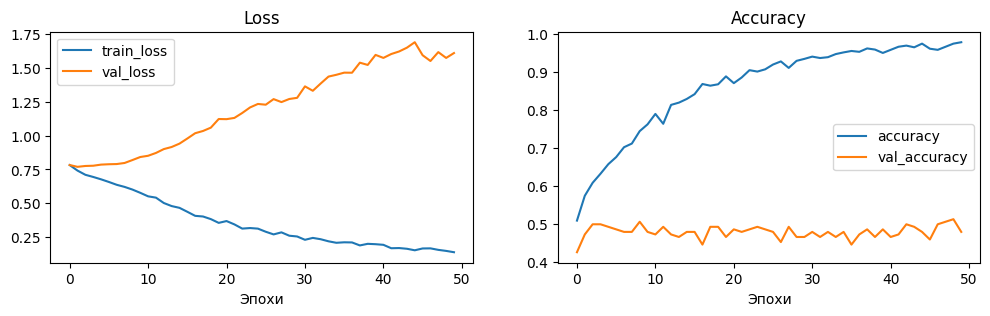

In [295]:
y_predict = model.predict(X_test, verbose=0)
y_predict = np.where(y_predict > 0.5, 1, 0)

plot_result_model(history)
metrics = calculate_metrics(y_test, y_predict)
df_results = add_results(df_results, metrics, 'Dense')
print_metrics(metrics, metrics_names)

In [296]:
# optimizers = ['sgd', 'rmsprop', 'adagrad', 'adadelta',
#               'adam', 'adamax', 'nadam']
# for optimizer in optimizers:
#     set_random_seed(RANDOM_SEED)
#     model = create_model(hl=1, hu=128, optimizer=optimazer,
#                          dropout=True, rate=.2, reg=None)
#     model.fit(X_train,
#               y_train,
#               epochs=50,
#               validation_split=0.1,
#               shuffle=False,
#               class_weight=class_weights(y_train.ravel()),
#               verbose=False
#               )
#     acc_tr = model.evaluate(X_train, y_train, verbose=False)[1]
#     acc_te = model.evaluate(X_test, y_test, verbose=False)[1]
#     out = f'{optimizer:10s} | in-sample={acc_tr:.4f}'
#     out += f' | out-of-sample={acc_te:.4f}'
#     print(out)

### RNN

In [303]:
def create_rnn_model(hl=2, hu=100, layer='SimpleRNN',
                     optimizer='rmsprop', features=1,
                     dropout=0.3, lags=None):

    if layer == 'SimpleRNN':
        layer = SimpleRNN
    elif layer == 'LSTM':
        layer = LSTM
    elif layer == 'GRU':
        layer = GRU
    else:
        raise ValueError

    model = Sequential()

    return_sequences = bool(hl)
    model.add(layer(hu, input_shape=(lags, features),
                    return_sequences=return_sequences,
                    ))
    if dropout:
        model.add(Dropout(dropout))
        
    for k in range(hl):
        if k == hl-1:
            model.add(layer(hu, return_sequences=False))
        else:
            model.add(layer(hu, return_sequences=True))
            if dropout:
                model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [305]:
%%time
set_random_seed(RANDOM_SEED)

learning_rate = 0.0008
epochs = 50
batch_size = 32
layer='LSTM'

optimazer = Adam(learning_rate=learning_rate)
model = create_rnn_model(hl=1, hu=100, layer=layer,
                         optimizer=optimazer, features=n_features,
                         dropout=0.2, lags=history_points)

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    shuffle=True,
                    class_weight=class_weights(y_train.ravel())
                    )
model.summary()

Epoch 1/50
43/43 [==============================] - 12s 122ms/step - loss: 0.6951 - accuracy: 0.4859 - val_loss: 0.6913 - val_accuracy: 0.5400
Epoch 2/50
43/43 [==============================] - 3s 77ms/step - loss: 0.6928 - accuracy: 0.5163 - val_loss: 0.6908 - val_accuracy: 0.5467
Epoch 3/50
43/43 [==============================] - 3s 77ms/step - loss: 0.6928 - accuracy: 0.5178 - val_loss: 0.6868 - val_accuracy: 0.5467
Epoch 4/50
43/43 [==============================] - 3s 78ms/step - loss: 0.6926 - accuracy: 0.5222 - val_loss: 0.6865 - val_accuracy: 0.5467
Epoch 5/50
43/43 [==============================] - 3s 76ms/step - loss: 0.6919 - accuracy: 0.5111 - val_loss: 0.6911 - val_accuracy: 0.5133
Epoch 6/50
43/43 [==============================] - 3s 79ms/step - loss: 0.6908 - accuracy: 0.5289 - val_loss: 0.6825 - val_accuracy: 0.5533
Epoch 7/50
43/43 [==============================] - 3s 78ms/step - loss: 0.6910 - accuracy: 0.5119 - val_loss: 0.6901 - val_accuracy: 0.5267
Epoch 8/50


ACC: 0.45325779036827196
F1: 0.4623955431754874
ROC-AUC: 0.45461737164998384


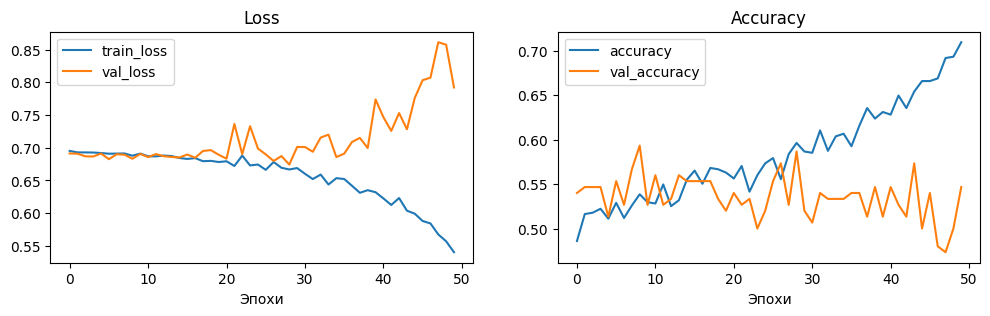

In [306]:
y_predict = model.predict(X_test, verbose=0)
y_predict = np.where(y_predict > 0.5, 1, 0)

plot_result_model(history)
metrics = calculate_metrics(y_test, y_predict)
df_results = add_results(df_results, metrics, layer)
print_metrics(metrics, metrics_names)

In [307]:
df_results.sort_values(metrics_names)

,model,ACC,F1,ROC-AUC
3,LSTM,0.453258,0.462396,0.454617
2,Dense,0.481586,0.490251,0.483113
0,baseline,0.532578,0.564644,0.530045
1,EMA,0.538244,0.576623,0.534437


Новости:
+ https://towardsdatascience.com/making-a-continual-ml-pipeline-to-predict-apple-stock-with-global-news-python-90e5d6610b21
+ https://medium.com/swlh/build-a-ml-web-app-for-stock-market-prediction-from-daily-news-with-streamlit-and-python-7c4cf918d9b4

Два входа в НС:
+ https://russianblogs.com/article/9801957431/

Доверительный интервал:
+ https://regenerativetoday.com/a-complete-guide-to-confidence-interval-and-calculation-in-python/

Броуновское движение:
+ https://www.kaggle.com/code/yclaudel/could-we-ve-predicted-the-spike-of-tesla-s-stock/notebook
+ https://towardsdatascience.com/simulating-stock-prices-in-python-using-geometric-brownian-motion-8dfd6e8c6b18
+ https://medium.com/fintechexplained/what-is-brownian-motion-36de732b1645

Математика случайности:
+ https://towardsdatascience.com/how-the-mathematics-of-fractals-can-help-predict-stock-markets-shifts-19fee5dd6574
+ https://towardsdatascience.com/monte-carlo-simulation-a-practical-guide-85da45597f0e